In [1]:
import pandas as pd
import json
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import squarify
import matplotlib.dates as mdates

%matplotlib inline

## Read porftolio function

In [2]:
def read_portfolio(filename):
    df = pd.read_csv(filename)
    
    row = df.iloc[0]
    
    portfolio = {
        'error': row['Error'],
        'weights': json.loads(row['Portfolio Weights']),
        'performance': {
            'train_performance': {
                'tracking_error': row['Train Tracking Error'],
                'root_mean_squared_error': row['Train RMSE'],
                'correlation': row['Train Correlation']
            },
            'test_performance': {
                'tracking_error': row['Test Tracking Error'],
                'root_mean_squared_error': row['Test RMSE'],
                'correlation': row['Test Correlation']
            }
        },
        'optimization_time': row['Optimization Time'],
        'mip_gap': row['Mip Gap'],
        'dates': {
            'train': {
                'start': row['Start train'],
                'end': row['End train'],
            },
            'test': {
                'start': row['Start test'],
                'end': row['End test'],
            }
        }
    }
    return portfolio

## Plot functions

In [3]:
def plot_portfolio(portfolio, stocks_data, index_data, start_date, end_date, index_name, yaxis_name='Cumulative Returns'):
    test_start = pd.Timestamp(portfolio['dates']['test']['start'])
    test_end = pd.Timestamp(portfolio['dates']['test']['end'])
    train_start = pd.Timestamp(portfolio['dates']['train']['start'])
    train_end = pd.Timestamp(portfolio['dates']['train']['end'])
    
    portfolio_weights = portfolio['weights']
    selected_stocks = stocks_data.columns
    weights = pd.Series(portfolio_weights).reindex(selected_stocks).values
    portfolio_data_filtered = (stocks_data * weights).sum(axis=1).loc[start_date:end_date]
    index_data_filtered = index_data.loc[start_date:end_date]

    portfolio_data_filtered.index = pd.to_datetime(portfolio_data_filtered.index)
    index_data_filtered.index = pd.to_datetime(index_data_filtered.index)

    available_dates = portfolio_data_filtered.index
    next_date = available_dates[available_dates >= test_start].min()
    
    if pd.isna(next_date):
        print("Warning: No available date after test_start in the plotting range.")
        next_date = None

    fig = plt.figure(figsize=(15, 8), facecolor='black')
    axis = fig.add_axes([0, 0, 1, 1], facecolor='black')

    if(index_name=='S&P100'):
        color='red'
    else:
        color='royalblue'

    axis.plot(index_data_filtered.index, index_data_filtered, color=color, linestyle='-', linewidth=3, label=index_name)
    axis.plot(portfolio_data_filtered.index, portfolio_data_filtered, color='gold', linestyle='--', linewidth=2, label="Portfolio")

    vertical_lines = [
        (train_start, 'Train Start'),
        (train_end, 'Train End'),
    ]

    def find_next_date(target_date, available_dates):
        next_date = available_dates[available_dates >= target_date].min()
        if pd.isna(next_date):
            print(f"Aviso: Nenhuma data disponível após {target_date} no intervalo.")
            return None
        return next_date

    for line_date, label in vertical_lines:
        adjusted_date = find_next_date(line_date, portfolio_data_filtered.index)
        if adjusted_date:
            axis.axvline(x=adjusted_date, color='white', linestyle='--', linewidth=2)
            axis.text(adjusted_date, axis.get_ylim()[1], label,
                      rotation=90, verticalalignment='top',
                      horizontalalignment='right',
                      color='white', fontsize=12)


    limsup = 1.5 if index_name=='S&P100' else 1.4
    
    axis.set_xticks(index_data_filtered.index[::30])
    axis.set_ylim([0.9, limsup])
    axis.set_title(f"Portfolio ({len(portfolio_weights)} stocks) {index_name}: {start_date} to {end_date}", fontsize=22, color='white')
    axis.legend(loc='upper left', fontsize=12, facecolor='black', edgecolor='white', labelcolor='white')
    axis.set_ylabel(yaxis_name, fontsize=15, color='white')
    axis.set_xlabel('Date', fontsize=15, color='white')
    axis.tick_params(colors='white')
    axis.grid(color='gray', linestyle='--')

    plt.show()


In [4]:
def plot_portfolio_rebalance(portfolio, portfolio_rebalance, stocks_data, index_data, start_date, end_date, index_name, yaxis_name='Cumulative Returns'):

    test_start = pd.Timestamp(portfolio['dates']['test']['start'])
    test_end = pd.Timestamp(portfolio['dates']['test']['end'])
    train_start = pd.Timestamp(portfolio['dates']['train']['start'])
    train_end = pd.Timestamp(portfolio['dates']['train']['end'])

    test_start_rebalance = pd.Timestamp(portfolio_rebalance['dates']['test']['start'])
    test_end_rebalance = pd.Timestamp(portfolio_rebalance['dates']['test']['end'])
    train_start_rebalance = pd.Timestamp(portfolio_rebalance['dates']['train']['start'])
    train_end_rebalance = pd.Timestamp(portfolio_rebalance['dates']['train']['end'])

    selected_stocks = stocks_data.columns
    portfolio_weights = portfolio['weights']
    portfolio_weights_rebalance = portfolio_rebalance['weights']

    weights = pd.Series(portfolio_weights).reindex(selected_stocks).fillna(0).values
    weights_rebalance = pd.Series(portfolio_weights_rebalance).reindex(selected_stocks).fillna(0).values

    portfolio_data_filtered = (stocks_data * weights).sum(axis=1).loc[start_date:portfolio_rebalance['dates']['train']['start']]
    portfolio_data_filtered_rebalance = (stocks_data * weights_rebalance).sum(axis=1).loc[portfolio_rebalance['dates']['train']['start']:end_date]
    index_data_filtered = index_data.loc[start_date:end_date]

    portfolio_data_filtered.index = pd.to_datetime(portfolio_data_filtered.index)
    portfolio_data_filtered_rebalance.index = pd.to_datetime(portfolio_data_filtered_rebalance.index)
    index_data_filtered.index = pd.to_datetime(index_data_filtered.index)

    if not portfolio_data_filtered.empty and not portfolio_data_filtered_rebalance.empty:
        final_value_before = portfolio_data_filtered.iloc[-1]
        portfolio_data_filtered_rebalance = portfolio_data_filtered_rebalance * (final_value_before / portfolio_data_filtered_rebalance.iloc[0])

    portfolio_combined = pd.concat([portfolio_data_filtered, portfolio_data_filtered_rebalance])

    def find_next_date(target_date, available_dates):
        next_date = available_dates[available_dates >= target_date].min()
        if pd.isna(next_date):
            print(f"Aviso: Nenhuma data disponível após {target_date} no intervalo.")
            return None
        return next_date

    fig = plt.figure(figsize=(15, 8), facecolor='black')
    axis = fig.add_axes([0, 0, 1, 1], facecolor='black')

    color = 'red' if index_name == 'S&P100' else 'royalblue'

    axis.plot(index_data_filtered.index, index_data_filtered, color=color, linestyle='-', linewidth=3, label=index_name)
    axis.plot(portfolio_combined.index, portfolio_combined, color='gold', linestyle='--', linewidth=2, label="Portfolio")

    vertical_lines = [
        (train_start, 'Train Start'),
        (train_end, 'Train End'),
        (train_start_rebalance, 'Rebalance Start'),
        (train_end_rebalance, 'Rebalance End')
    ]

    for line_date, label in vertical_lines:
        adjusted_date = find_next_date(line_date, portfolio_combined.index)
        if adjusted_date:
            axis.axvline(x=adjusted_date, color='white', linestyle='--', linewidth=2)
            axis.text(adjusted_date, axis.get_ylim()[1], label,
                      rotation=90, verticalalignment='top',
                      horizontalalignment='right',
                      color='white', fontsize=12)

    limsup = 1.5 if index_name=='S&P100' else 1.4

    axis.set_xticks(index_data_filtered.index[::30])
    axis.set_ylim([0.9, limsup])
    axis.set_title(f"Portfolio ({len(portfolio_weights)} stocks) {index_name}: {start_date} to {end_date}", fontsize=22, color='white')
    axis.legend(loc='upper left', fontsize=12, facecolor='black', edgecolor='white', labelcolor='white')
    axis.set_ylabel(yaxis_name, fontsize=15, color='white')
    axis.set_xlabel('Date', fontsize=15, color='white')
    axis.tick_params(colors='white')
    axis.grid(color='gray', linestyle='--')

    plt.show()

In [5]:
def plot_weights(portfolio, index_name, rebalance=False):
    labels = list(portfolio.keys())
    values = list(portfolio.values())

    if(index_name=='S&P100'):
        colors = plt.cm.autumn([i / len(values) for i in range(len(values))])
    else:
        colors = plt.cm.Blues([i / len(values) for i in range(len(values))])

    plt.figure(figsize=(12, 8), facecolor='black')
    ax = plt.gca()
    ax.set_facecolor('black')

    squarify.plot(
        sizes=values,
        label=labels,
        alpha=0.8,
        color=colors,
        text_kwargs={'color': 'white', 'fontsize': 12}
    )

    rebalace_str = 'Rebalance' if rebalance else ''
    plt.title(f"Treemap ({len(portfolio)} stocks) {index_name} {rebalace_str}", fontsize=18, color='white', pad=20)
    plt.axis('off')
    plt.show()



## Loading data

In [6]:
bvsp_index_ticker = '^BVSP'

bvsp_data_values = pd.read_csv('../data/stock_cumulative_returns_^BVSP.csv', index_col=0)  # Inclui o índice
bvsp_data_variance = pd.read_csv('../data/stock_variance_^BVSP.csv', index_col=0)

bvsp_index_values = bvsp_data_values[bvsp_index_ticker]
bvsp_stocks_values = bvsp_data_values.drop(columns=[bvsp_index_ticker])

bvsp_index_variance = bvsp_data_variance[bvsp_index_ticker]
bvsp_stocks_variance = bvsp_data_variance.drop(columns=[bvsp_index_ticker])

sp100_index_ticker = '^OEX'

sp100_data_values = pd.read_csv('../data/stock_cumulative_returns_^OEX.csv', index_col=0)  # Inclui o índice
sp100_data_variance = pd.read_csv('../data/stock_variance_^OEX.csv', index_col=0)

sp100_index_values = sp100_data_values[sp100_index_ticker]
sp100_stocks_values = sp100_data_values.drop(columns=[sp100_index_ticker])

sp100_index_variance = sp100_data_variance[sp100_index_ticker]
sp100_stocks_variance = sp100_data_variance.drop(columns=[sp100_index_ticker])

start_date_dataset = "2023-01-01"
end_date_dataset = "2023-12-31"
train_start = start_date_dataset
train_end = "2023-03-31"
test_start = "2023-04-01"
test_end = end_date_dataset

start_date_dataset_rebalance = "2023-07-01"
end_date_dataset_rebalance = "2023-12-31"
train_start_rebalance = start_date_dataset_rebalance
train_end_rebalance = "2023-09-30"
test_start_rebalance = "2023-10-01"
test_end_rebalance = end_date_dataset_rebalance

## Loading Portfolios:

In [7]:
regular_sp100_10stocks = read_portfolio("../portfolios/results/regular_sp100_10stocks.csv")
regular_sp100_20stocks = read_portfolio("../portfolios/results/regular_sp100_20stocks.csv")
regular_sp100_30stocks = read_portfolio("../portfolios/results/regular_sp100_30stocks.csv")

regular_bvsp_10stocks = read_portfolio("../portfolios/results/regular_bvsp_10stocks.csv")
regular_bvsp_20stocks = read_portfolio("../portfolios/results/regular_bvsp_20stocks.csv")
regular_bvsp_30stocks = read_portfolio("../portfolios/results/regular_bvsp_30stocks.csv")

initial_sp100_10stocks = read_portfolio("../portfolios/results/initial_sp100_10stocks.csv")
initial_sp100_20stocks = read_portfolio("../portfolios/results/initial_sp100_20stocks.csv")
initial_sp100_30stocks = read_portfolio("../portfolios/results/initial_sp100_30stocks.csv")

initial_bvsp_10stocks = read_portfolio("../portfolios/results/initial_bvsp_10stocks.csv")
initial_bvsp_20stocks = read_portfolio("../portfolios/results/initial_bvsp_20stocks.csv")
initial_bvsp_30stocks = read_portfolio("../portfolios/results/initial_bvsp_30stocks.csv")

## Rebalance

initial_rebalance_sp100_10stocks = read_portfolio("../portfolios/results/initial_rebalance_sp100_10stocks.csv")
initial_rebalance_sp100_20stocks = read_portfolio("../portfolios/results/initial_rebalance_sp100_20stocks.csv")
initial_rebalance_sp100_30stocks = read_portfolio("../portfolios/results/initial_rebalance_sp100_30stocks.csv")

initial_rebalance_bvsp_10stocks = read_portfolio("../portfolios/results/initial_rebalance_bvsp_10stocks.csv")
initial_rebalance_bvsp_20stocks = read_portfolio("../portfolios/results/initial_rebalance_bvsp_20stocks.csv")
initial_rebalance_bvsp_30stocks = read_portfolio("../portfolios/results/initial_rebalance_bvsp_30stocks.csv")

## Plotting Portfolio:

### SP100 10 stocks

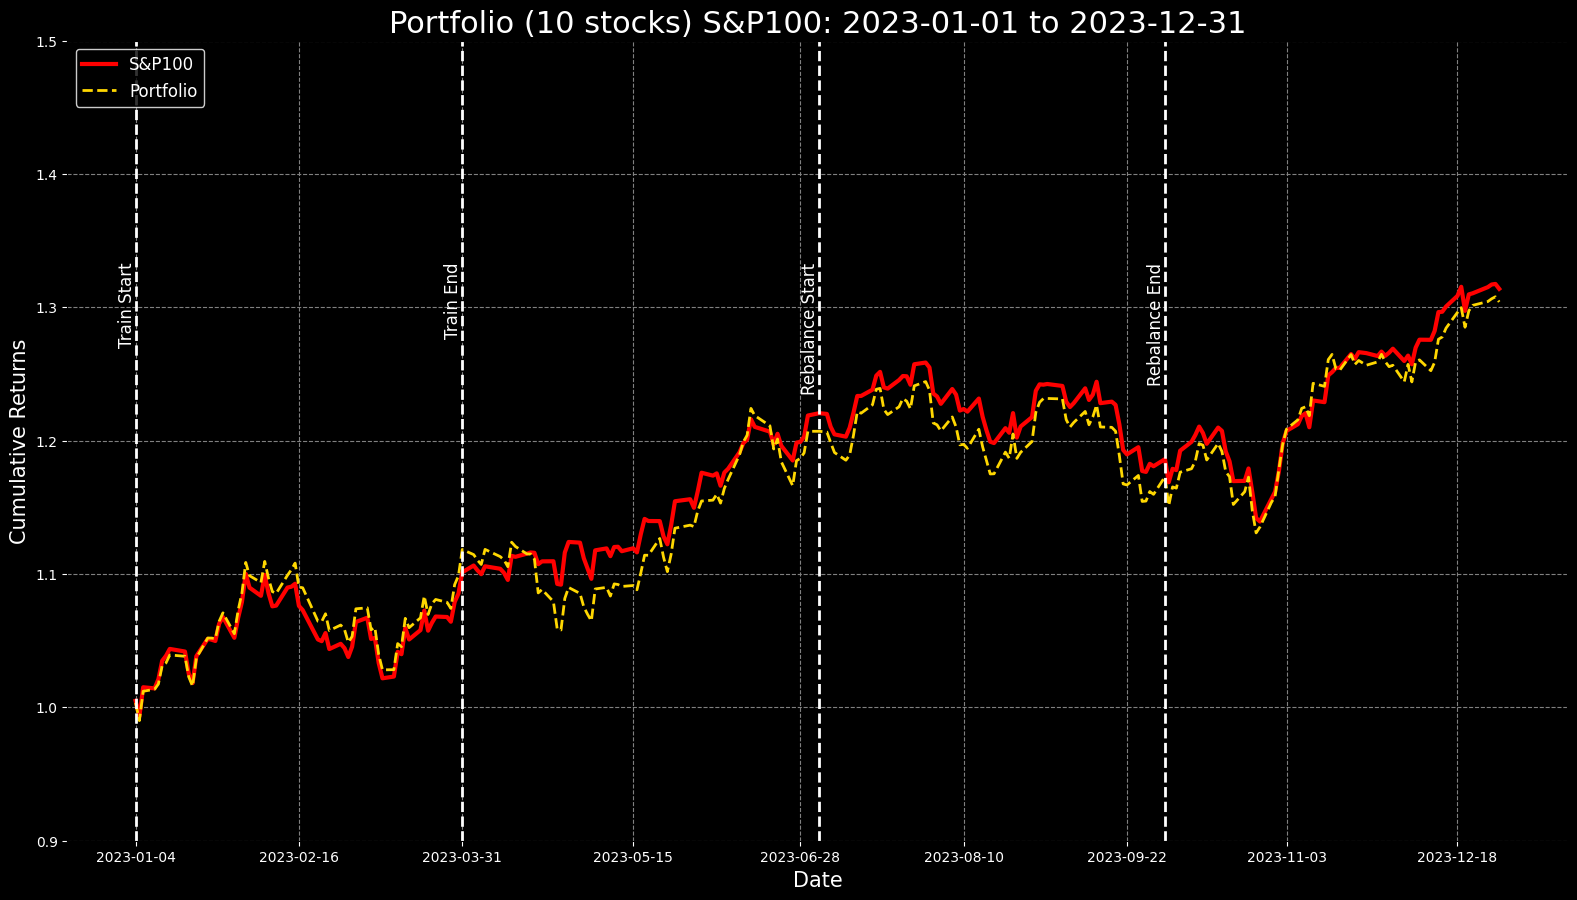

In [8]:
plot_portfolio_rebalance(initial_sp100_10stocks, initial_rebalance_sp100_10stocks, sp100_stocks_values, sp100_index_values, start_date_dataset, end_date_dataset, 'S&P100')

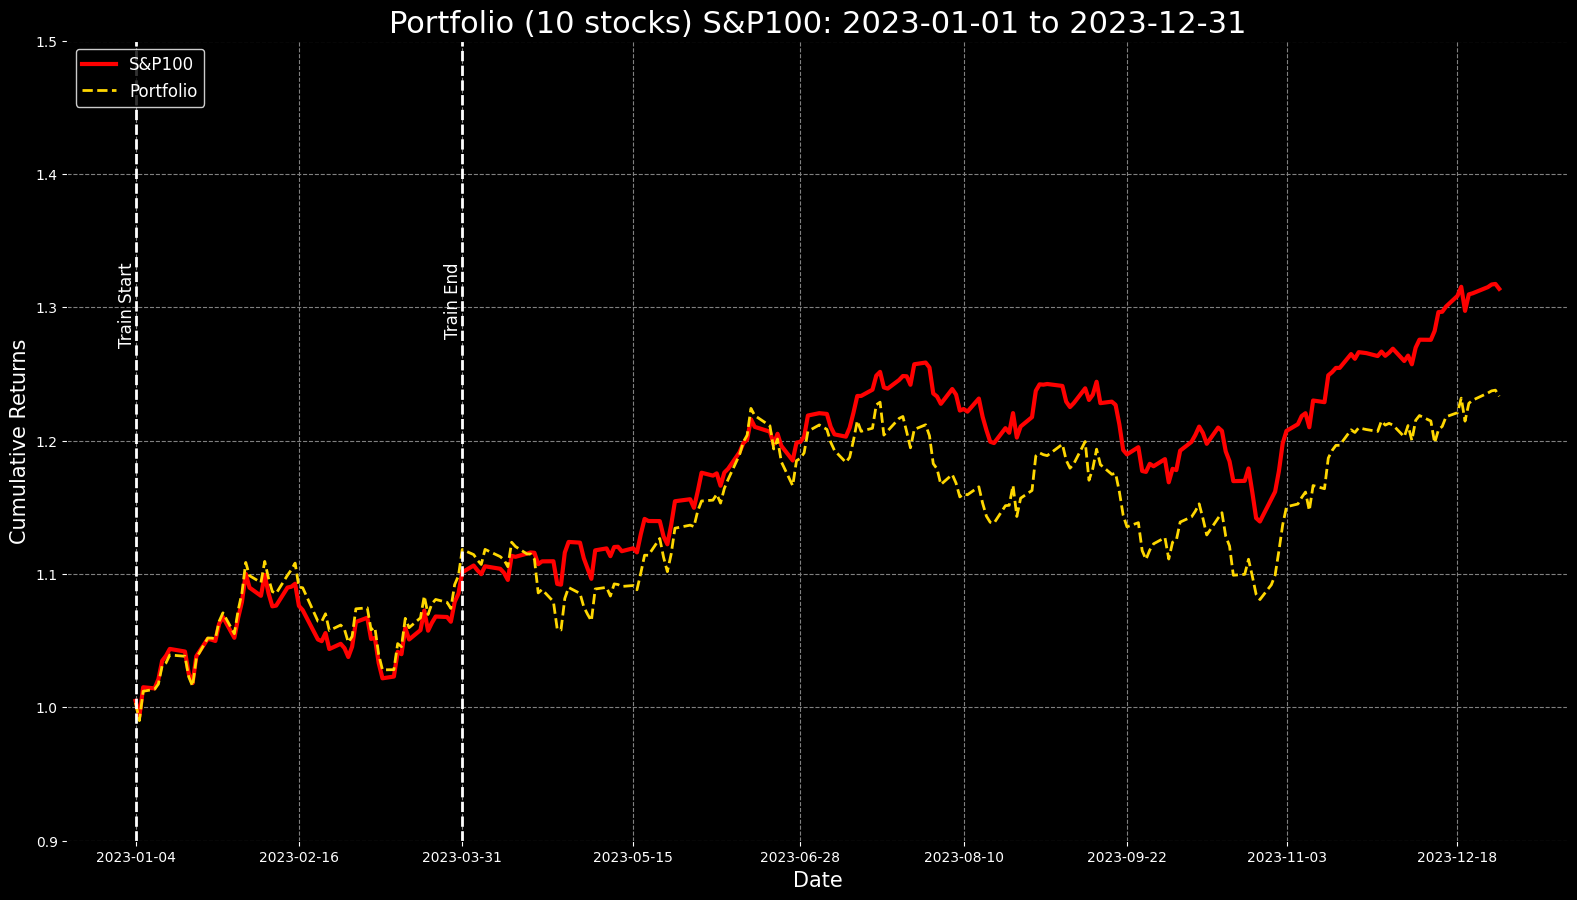

In [9]:
plot_portfolio(initial_sp100_10stocks, sp100_stocks_values, sp100_index_values, start_date_dataset, end_date_dataset, 'S&P100')

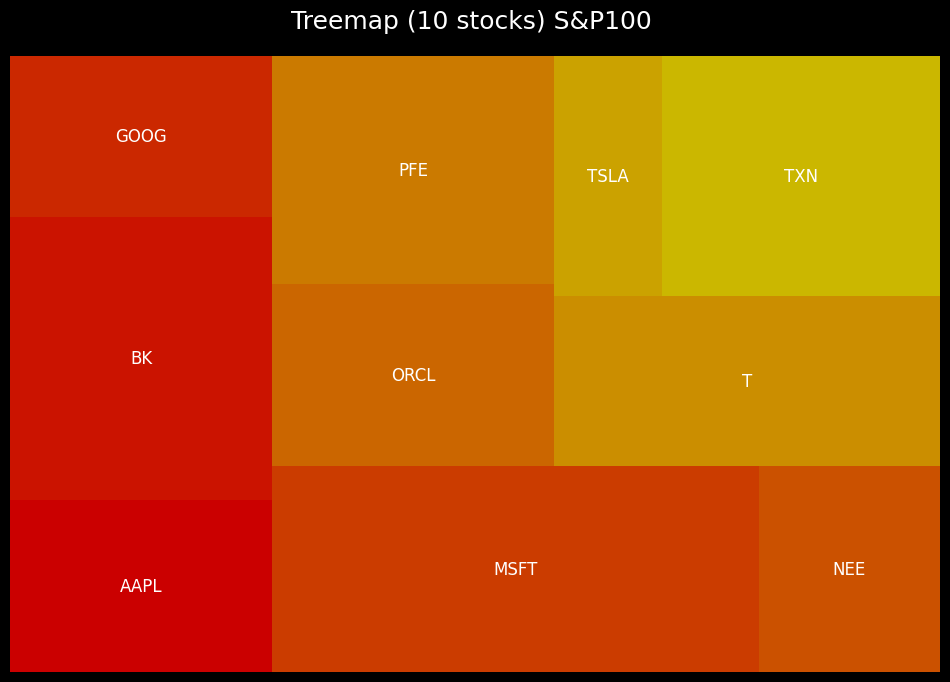

In [10]:
plot_weights(initial_sp100_10stocks['weights'], index_name='S&P100')

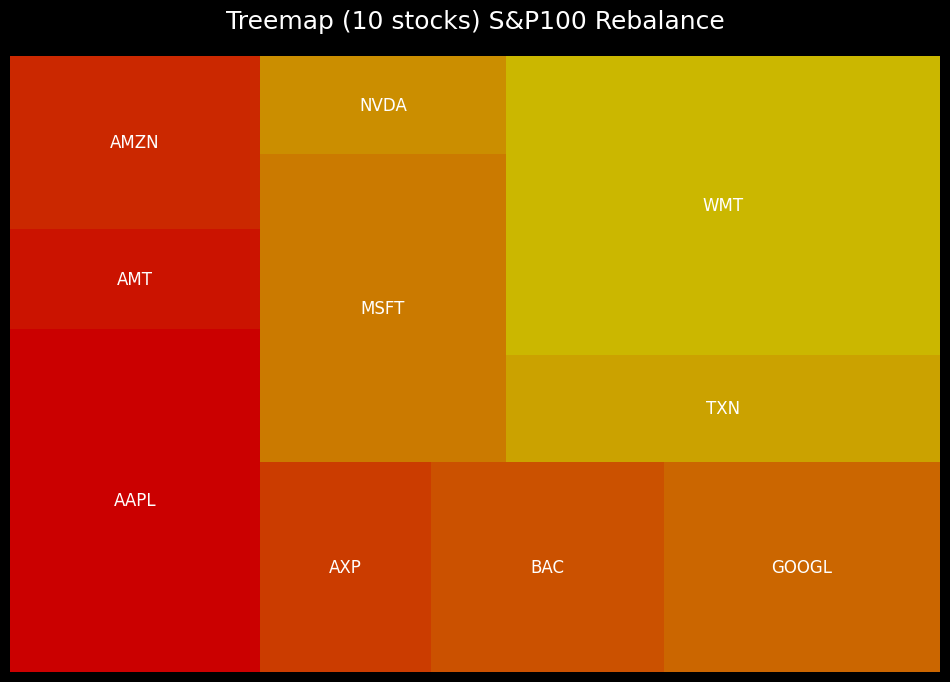

In [11]:
plot_weights(initial_rebalance_sp100_10stocks['weights'], index_name='S&P100', rebalance=True)

### SP100 20 stocks

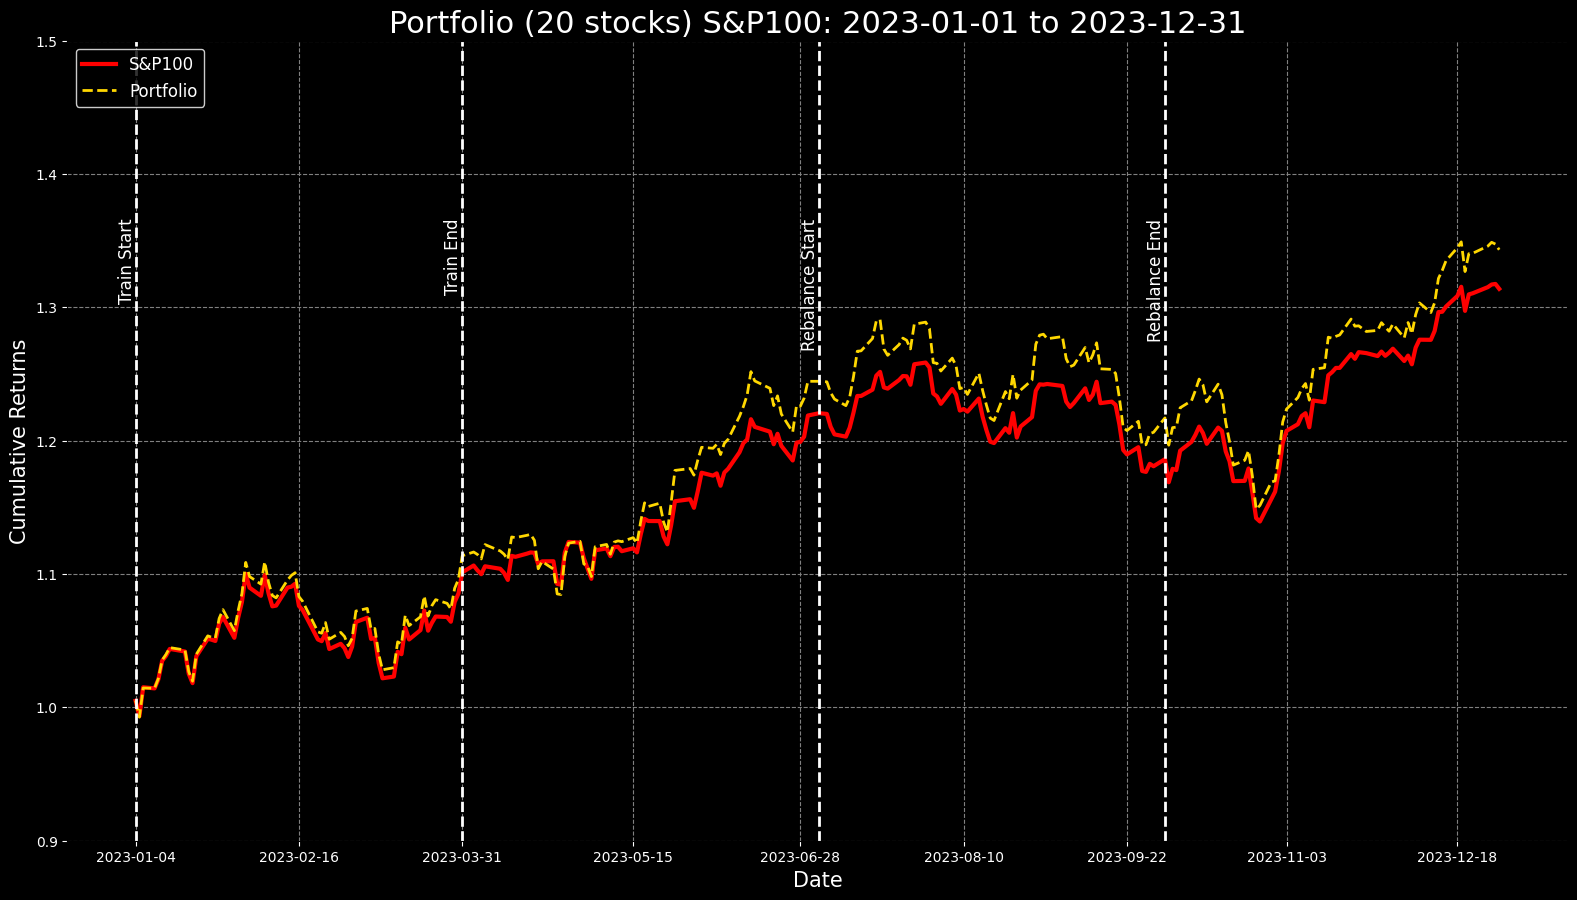

In [12]:
plot_portfolio_rebalance(initial_sp100_20stocks, initial_rebalance_sp100_20stocks, sp100_stocks_values, sp100_index_values, start_date_dataset, end_date_dataset, 'S&P100')

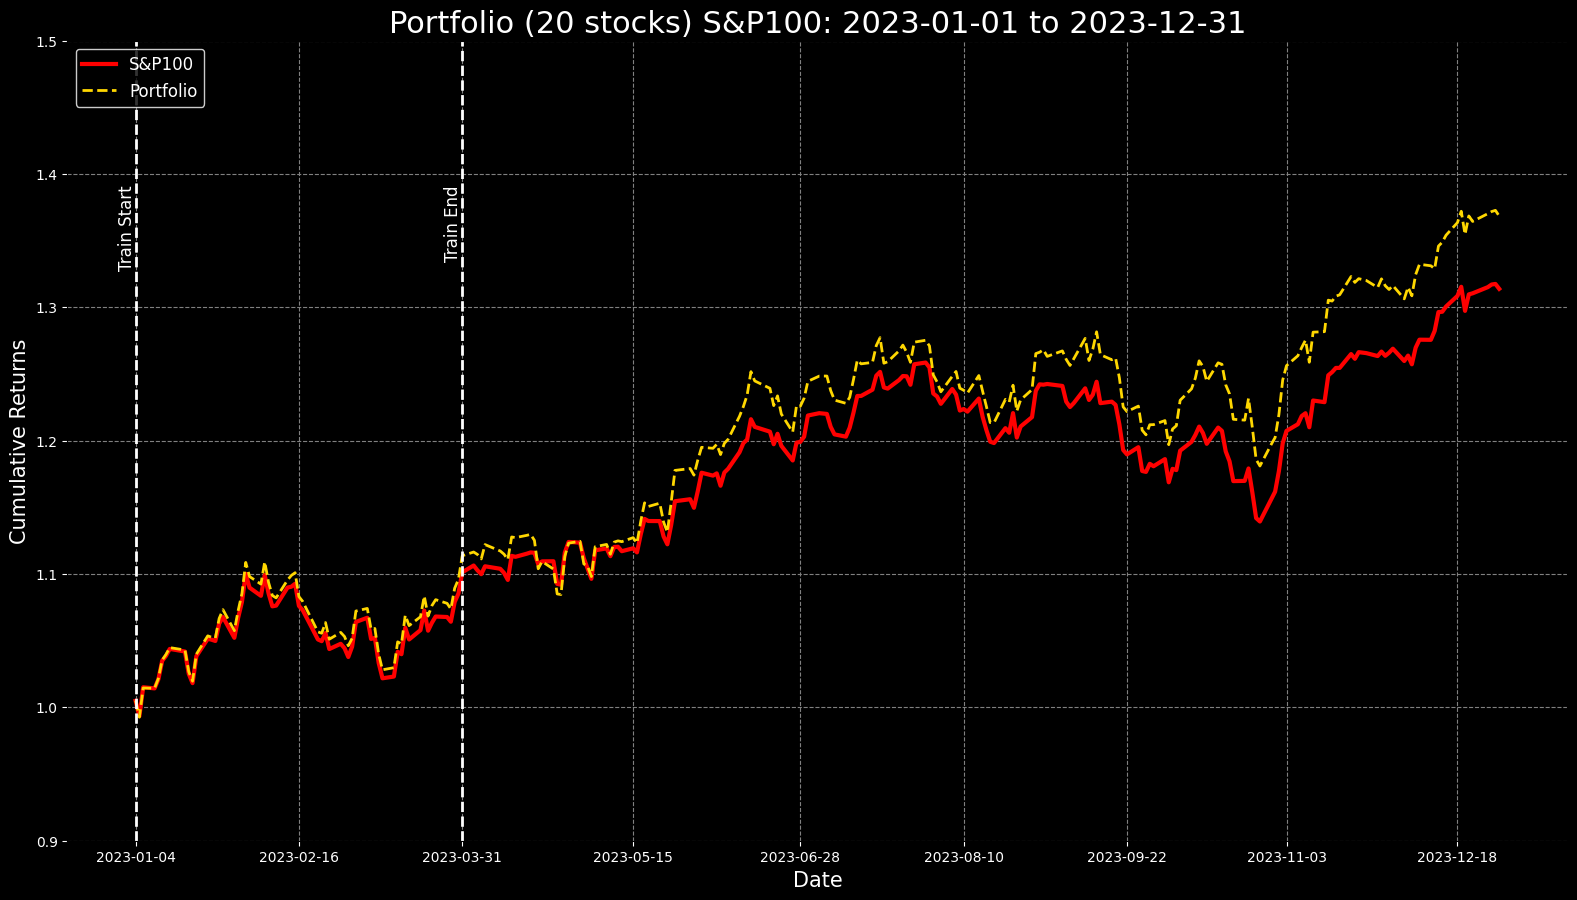

In [13]:
plot_portfolio(initial_sp100_20stocks, sp100_stocks_values, sp100_index_values, start_date_dataset, end_date_dataset, 'S&P100')

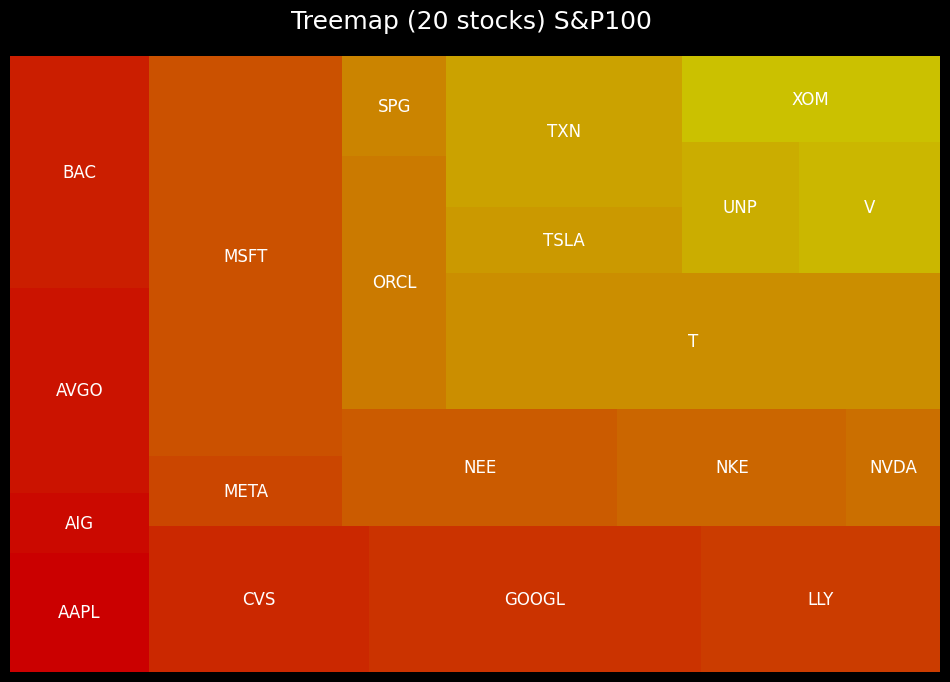

In [14]:
plot_weights(initial_sp100_20stocks['weights'], index_name='S&P100')

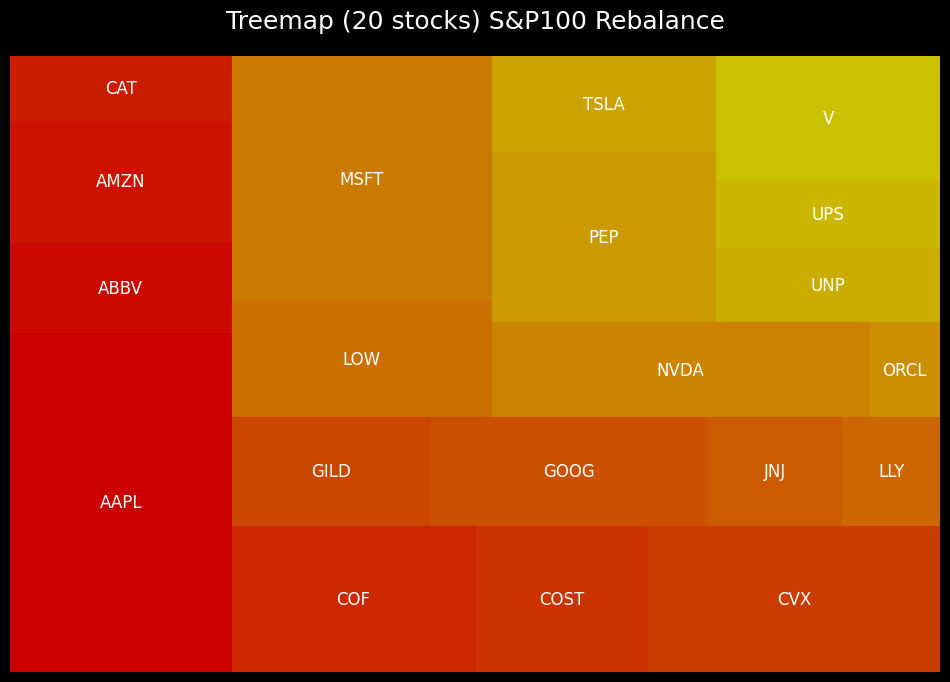

In [15]:
plot_weights(initial_rebalance_sp100_20stocks['weights'], index_name='S&P100', rebalance=True)

### SP100 30 stocks

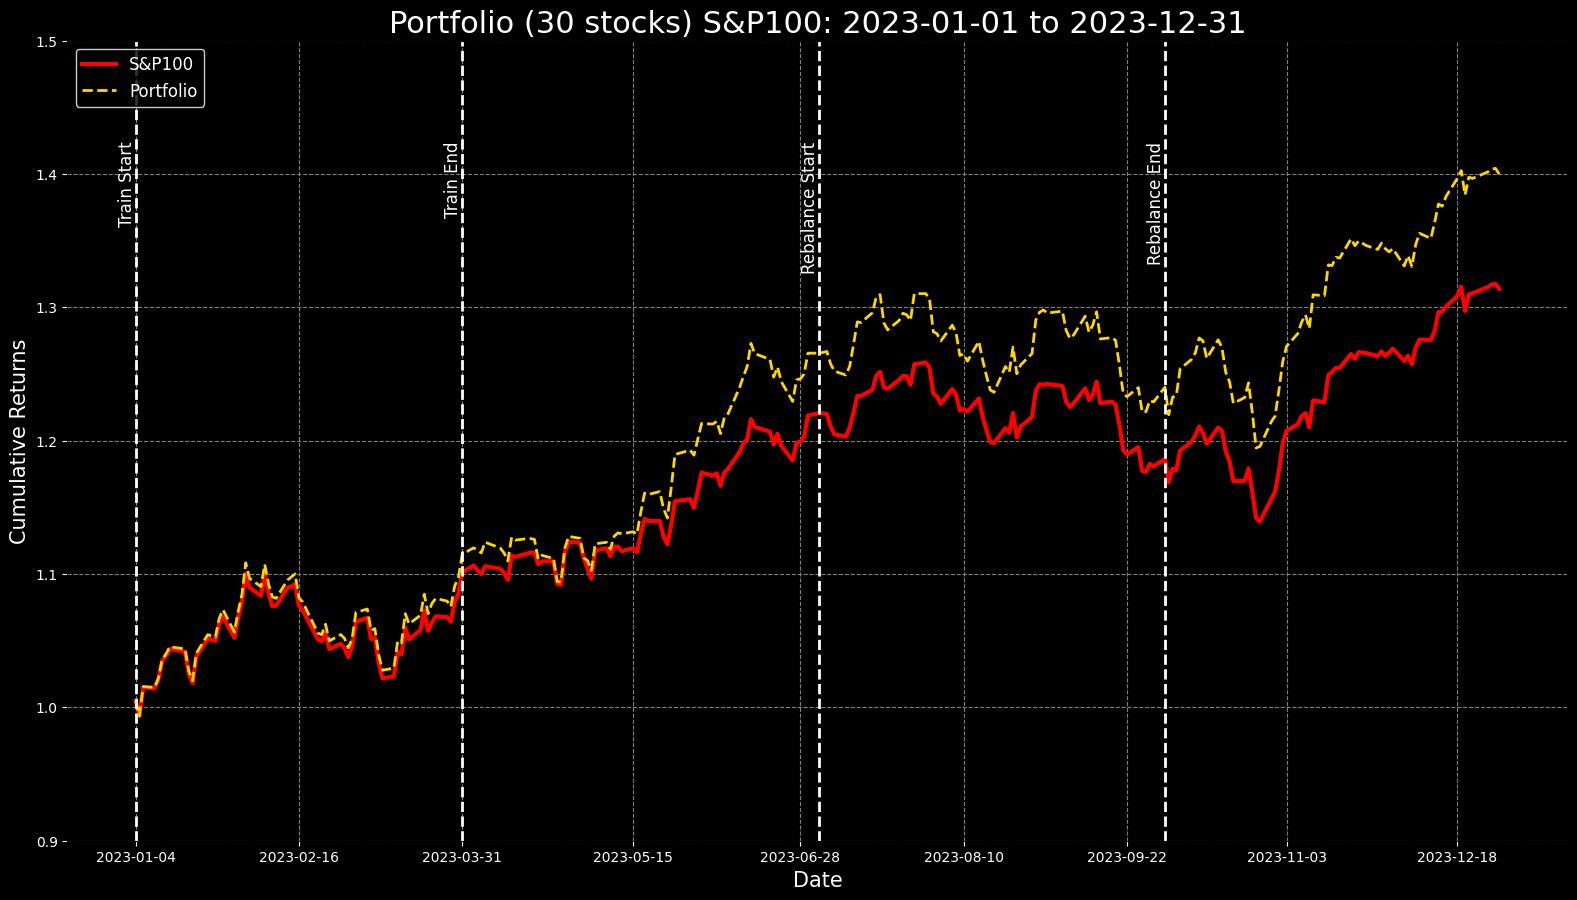

In [16]:
plot_portfolio_rebalance(initial_sp100_30stocks, initial_rebalance_sp100_30stocks, sp100_stocks_values, sp100_index_values, start_date_dataset, end_date_dataset, 'S&P100')

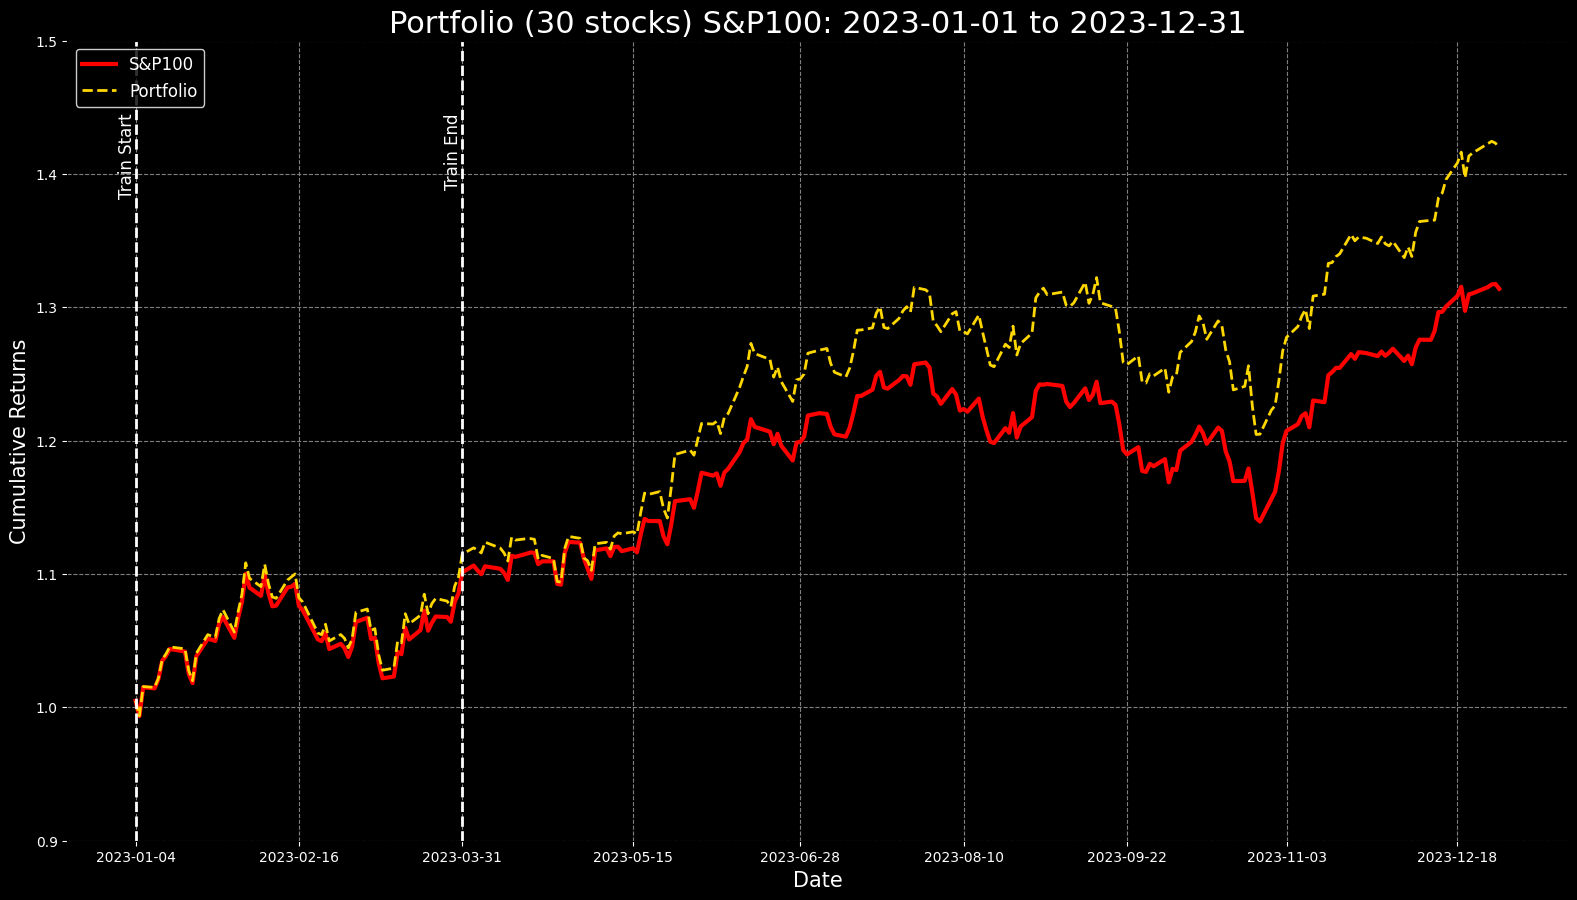

In [17]:
plot_portfolio(initial_sp100_30stocks, sp100_stocks_values, sp100_index_values, start_date_dataset, end_date_dataset, 'S&P100')

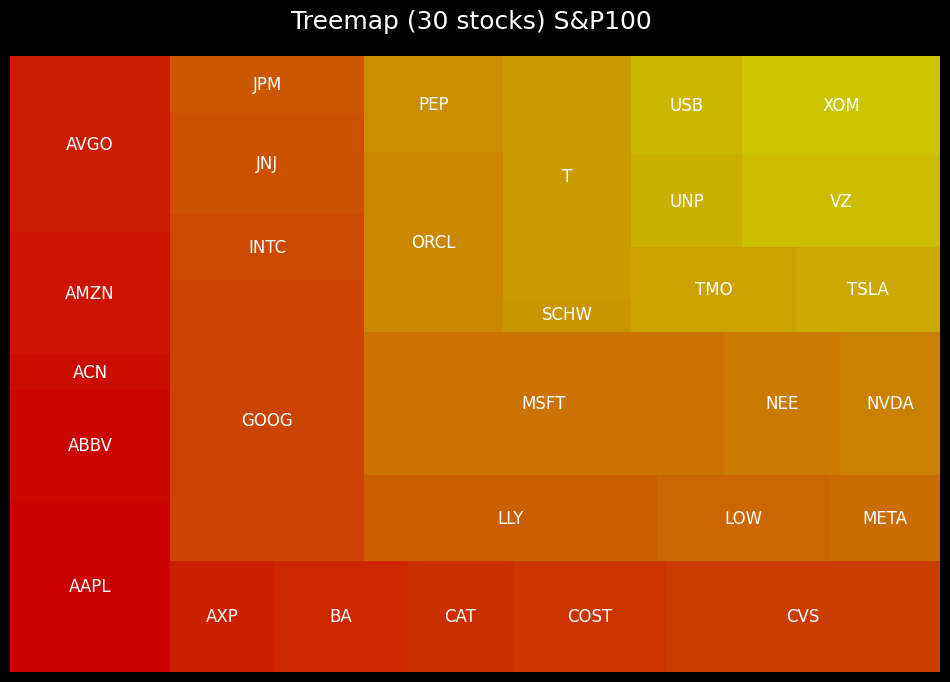

In [18]:
plot_weights(initial_sp100_30stocks['weights'], index_name='S&P100')

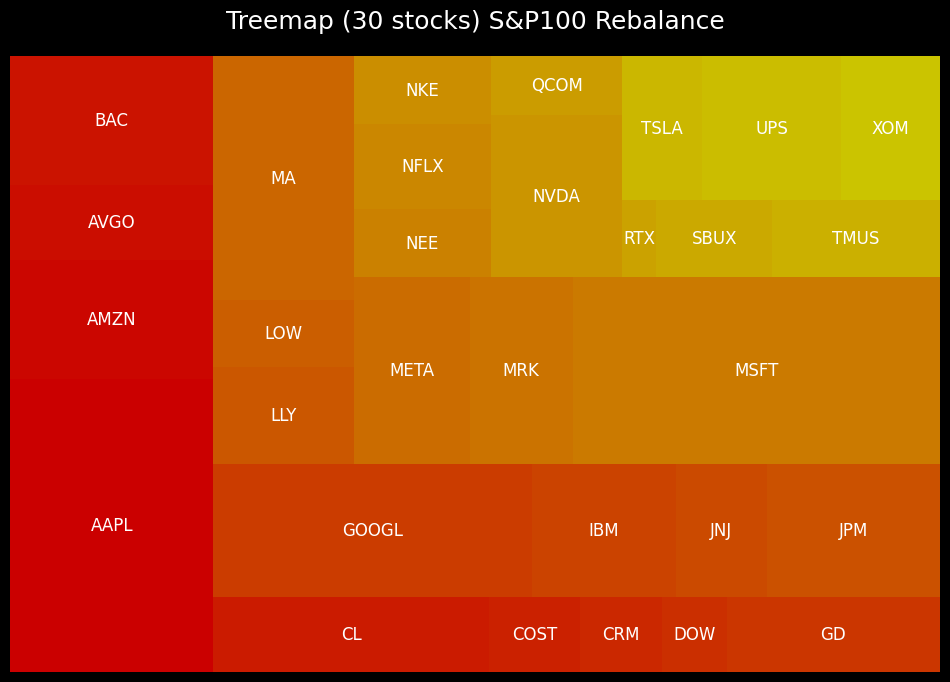

In [19]:
plot_weights(initial_rebalance_sp100_30stocks['weights'], index_name='S&P100', rebalance=True)

### Bvps 10 stocks

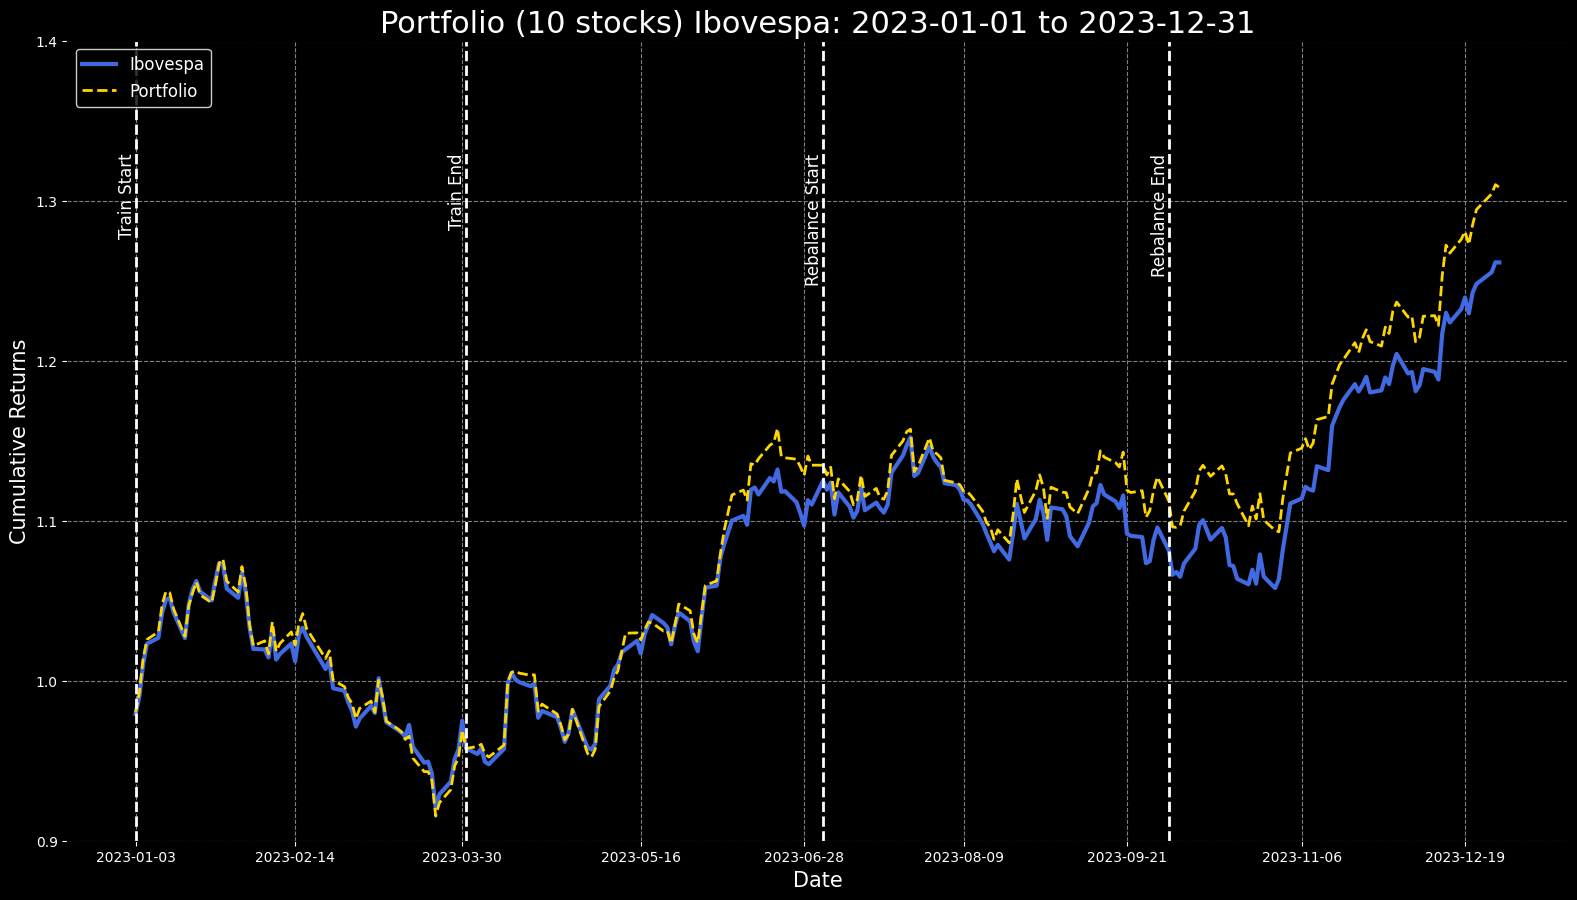

In [20]:
plot_portfolio_rebalance(initial_bvsp_10stocks, initial_rebalance_bvsp_10stocks, bvsp_stocks_values, bvsp_index_values, start_date_dataset, end_date_dataset, 'Ibovespa')

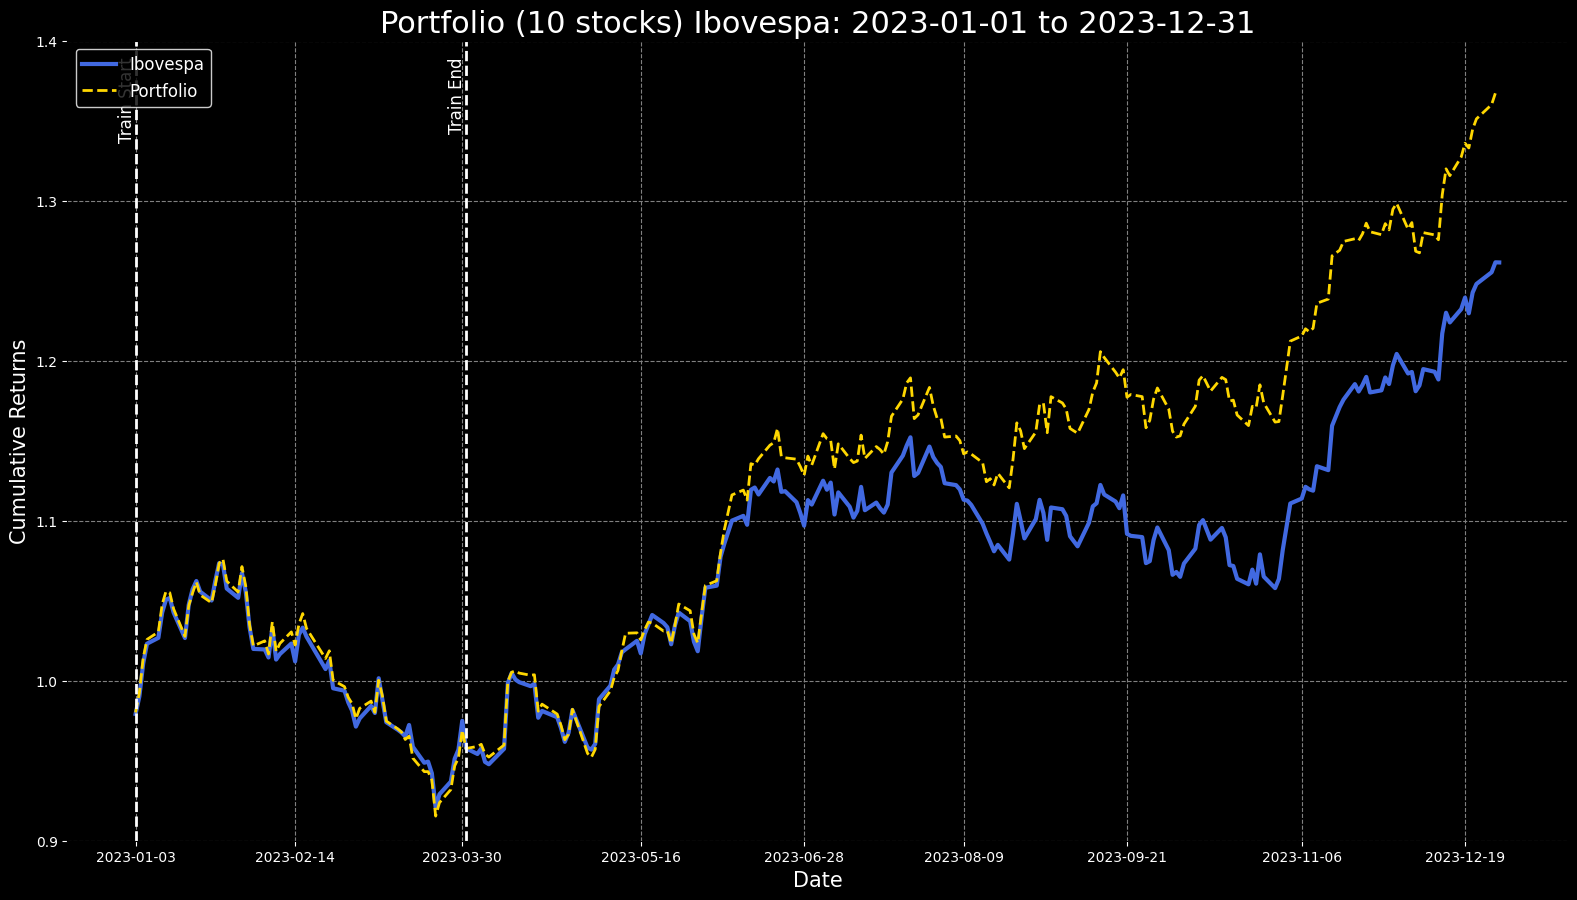

In [21]:
plot_portfolio(initial_bvsp_10stocks, bvsp_stocks_values, bvsp_index_values, start_date_dataset, end_date_dataset, 'Ibovespa')

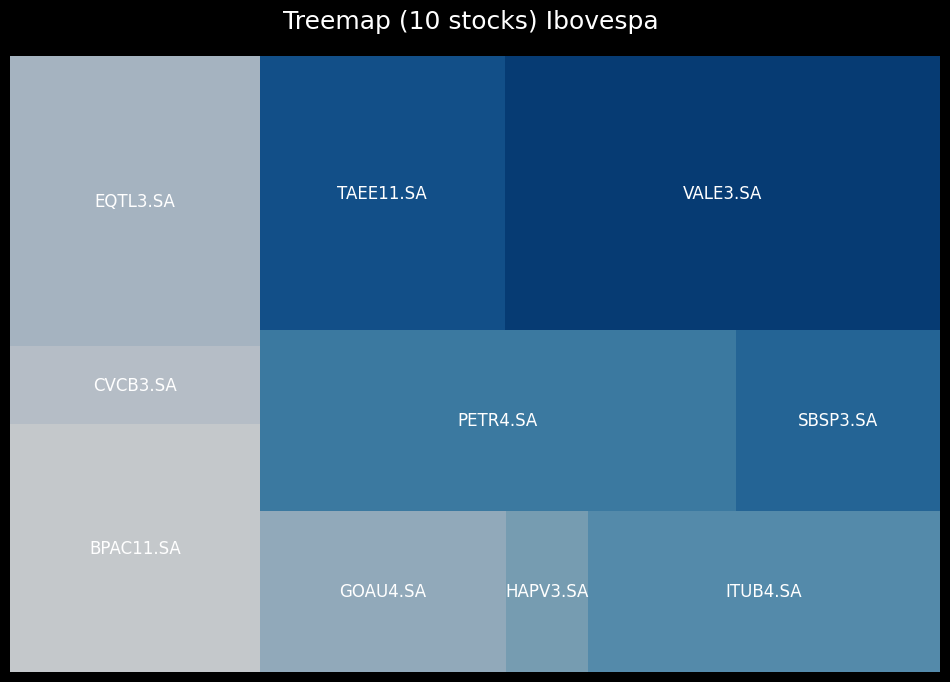

In [22]:
plot_weights(initial_bvsp_10stocks['weights'], index_name='Ibovespa')

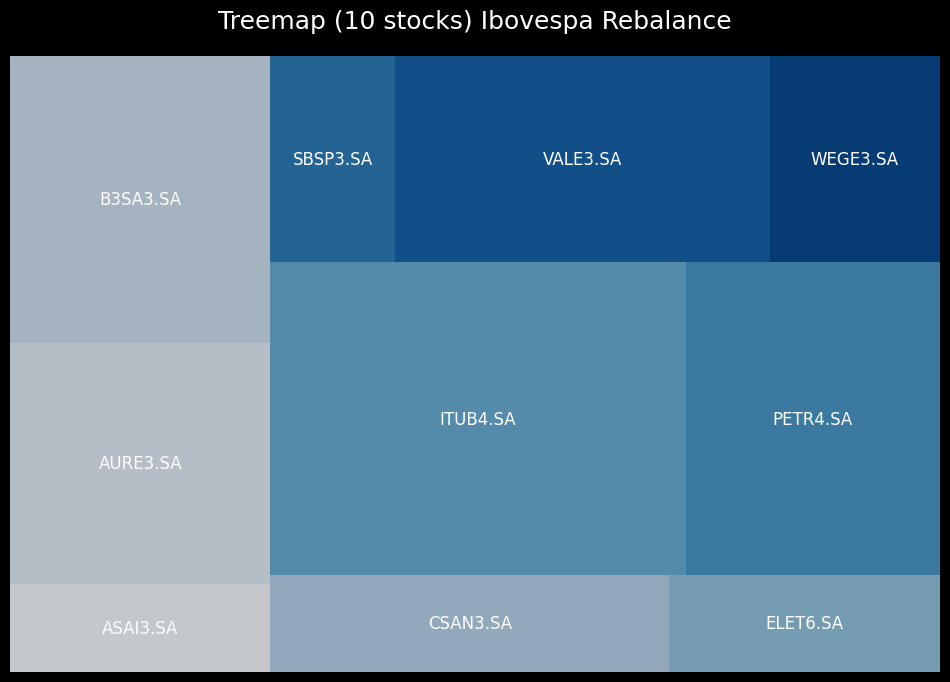

In [23]:
plot_weights(initial_rebalance_bvsp_10stocks['weights'], index_name='Ibovespa', rebalance=True)

### Bvsp 20 stocks

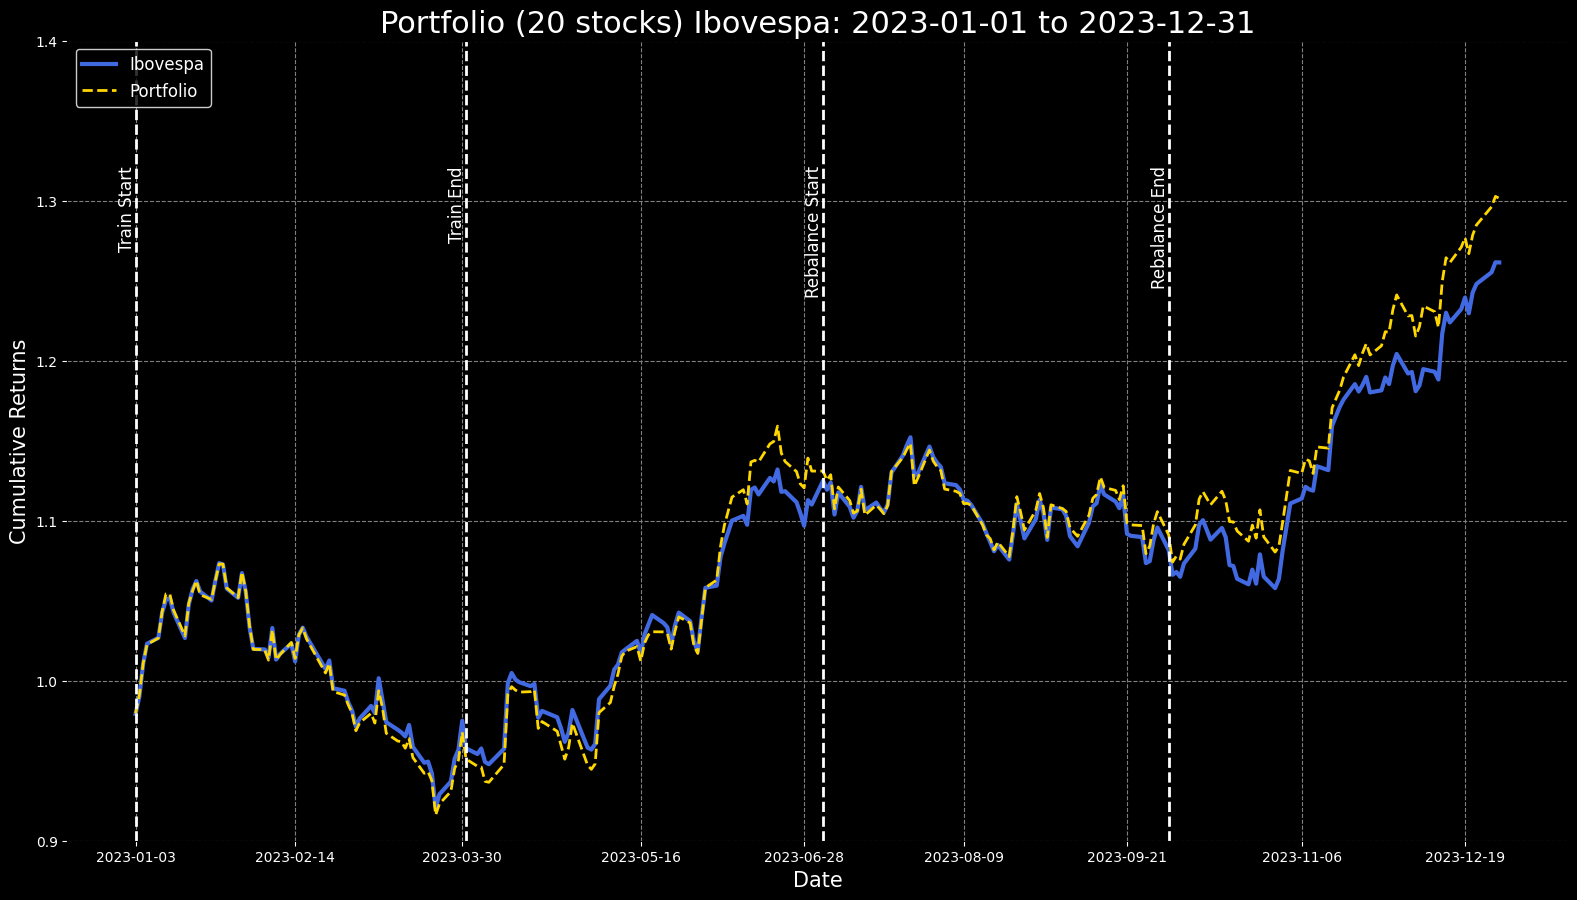

In [24]:
plot_portfolio_rebalance(initial_bvsp_20stocks, initial_rebalance_bvsp_20stocks, bvsp_stocks_values, bvsp_index_values, start_date_dataset, end_date_dataset, 'Ibovespa')

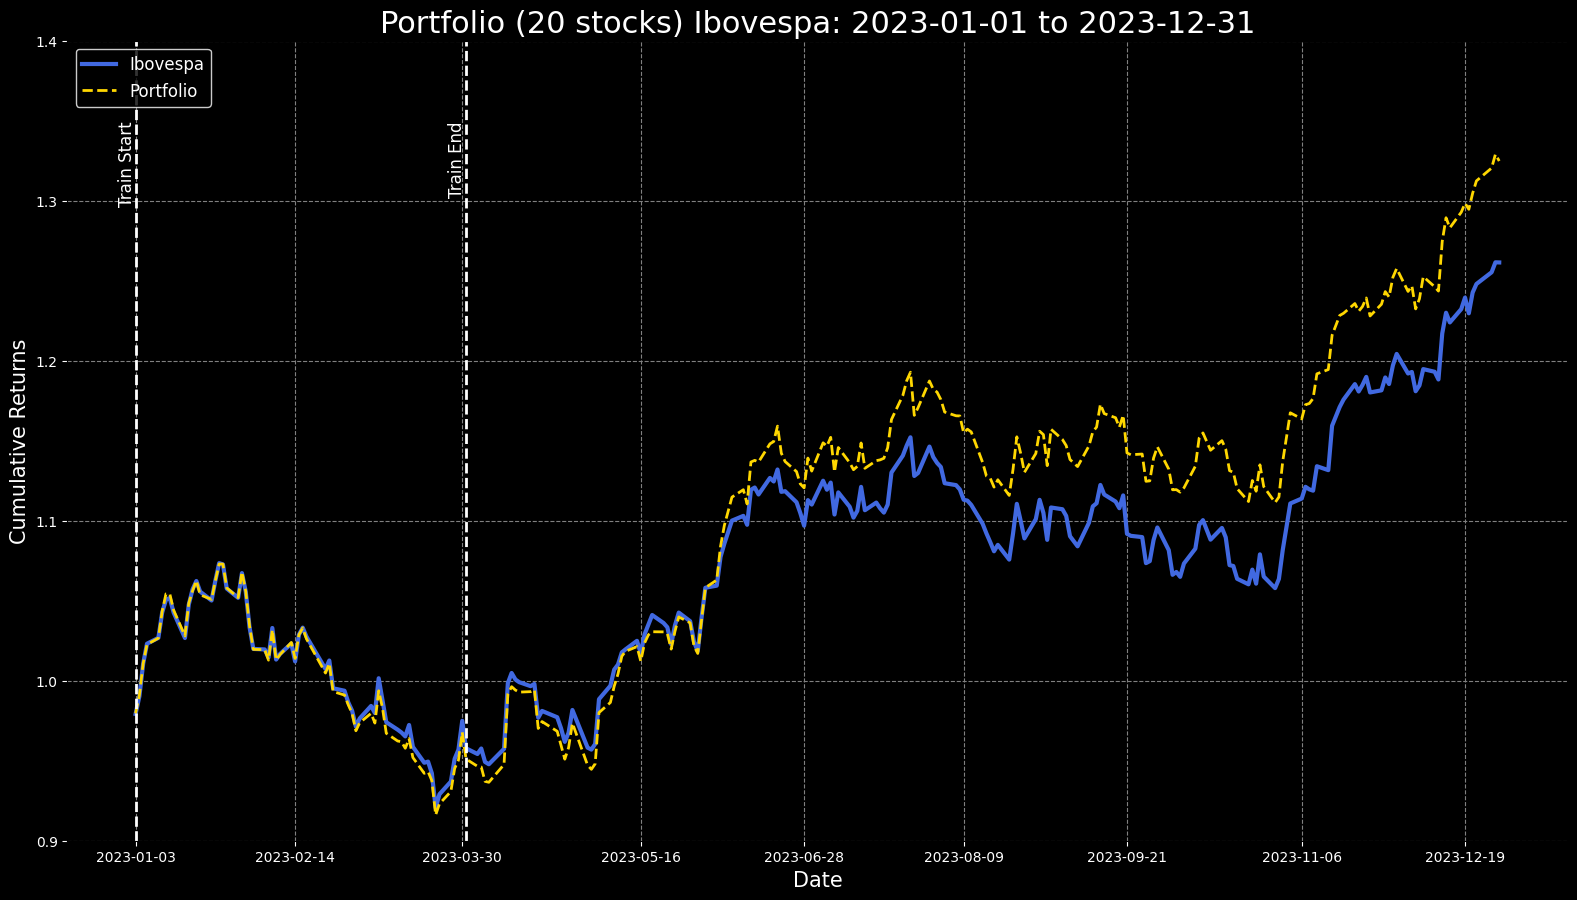

In [25]:
plot_portfolio(initial_bvsp_20stocks, bvsp_stocks_values, bvsp_index_values, start_date_dataset, end_date_dataset, 'Ibovespa')

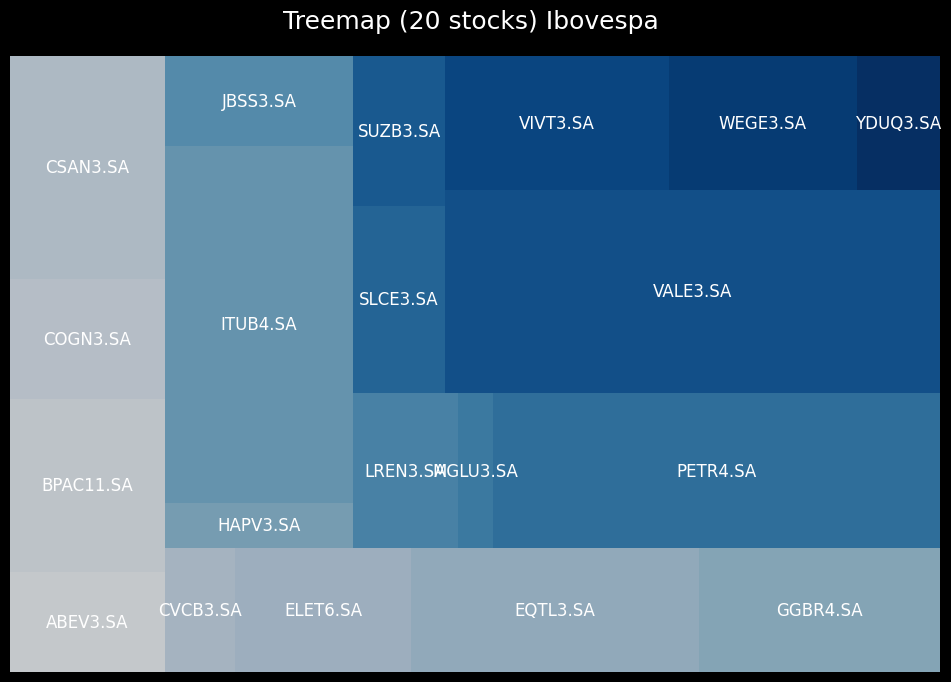

In [26]:
plot_weights(initial_bvsp_20stocks['weights'], index_name='Ibovespa')

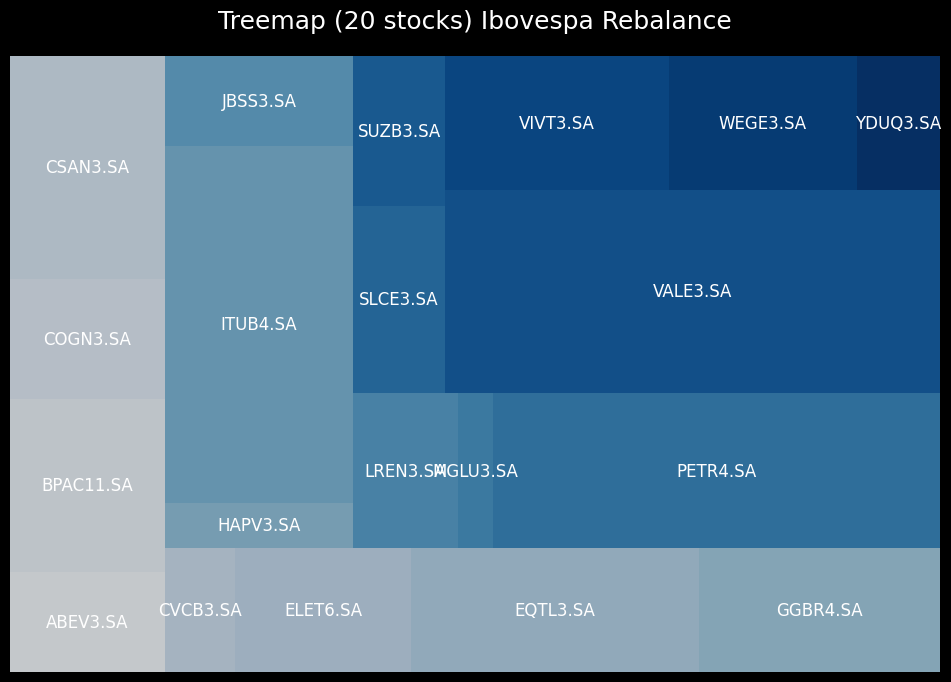

In [27]:
plot_weights(initial_bvsp_20stocks['weights'], index_name='Ibovespa', rebalance=True)

### Bvsp 30 stocks

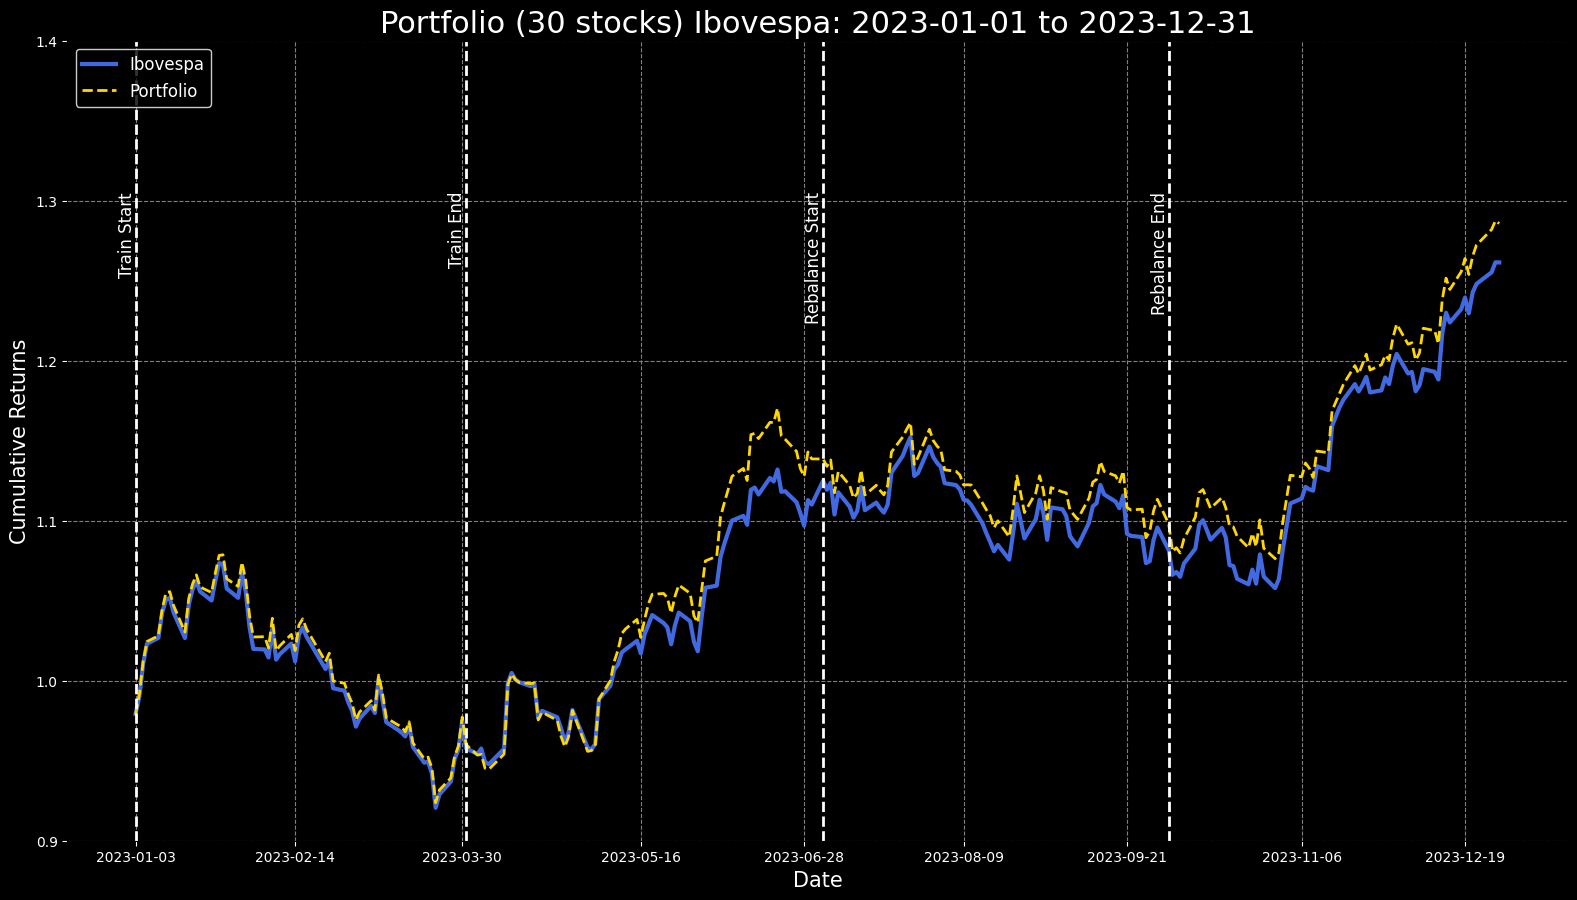

In [28]:
plot_portfolio_rebalance(initial_bvsp_30stocks, initial_rebalance_bvsp_30stocks, bvsp_stocks_values, bvsp_index_values, start_date_dataset, end_date_dataset, 'Ibovespa')

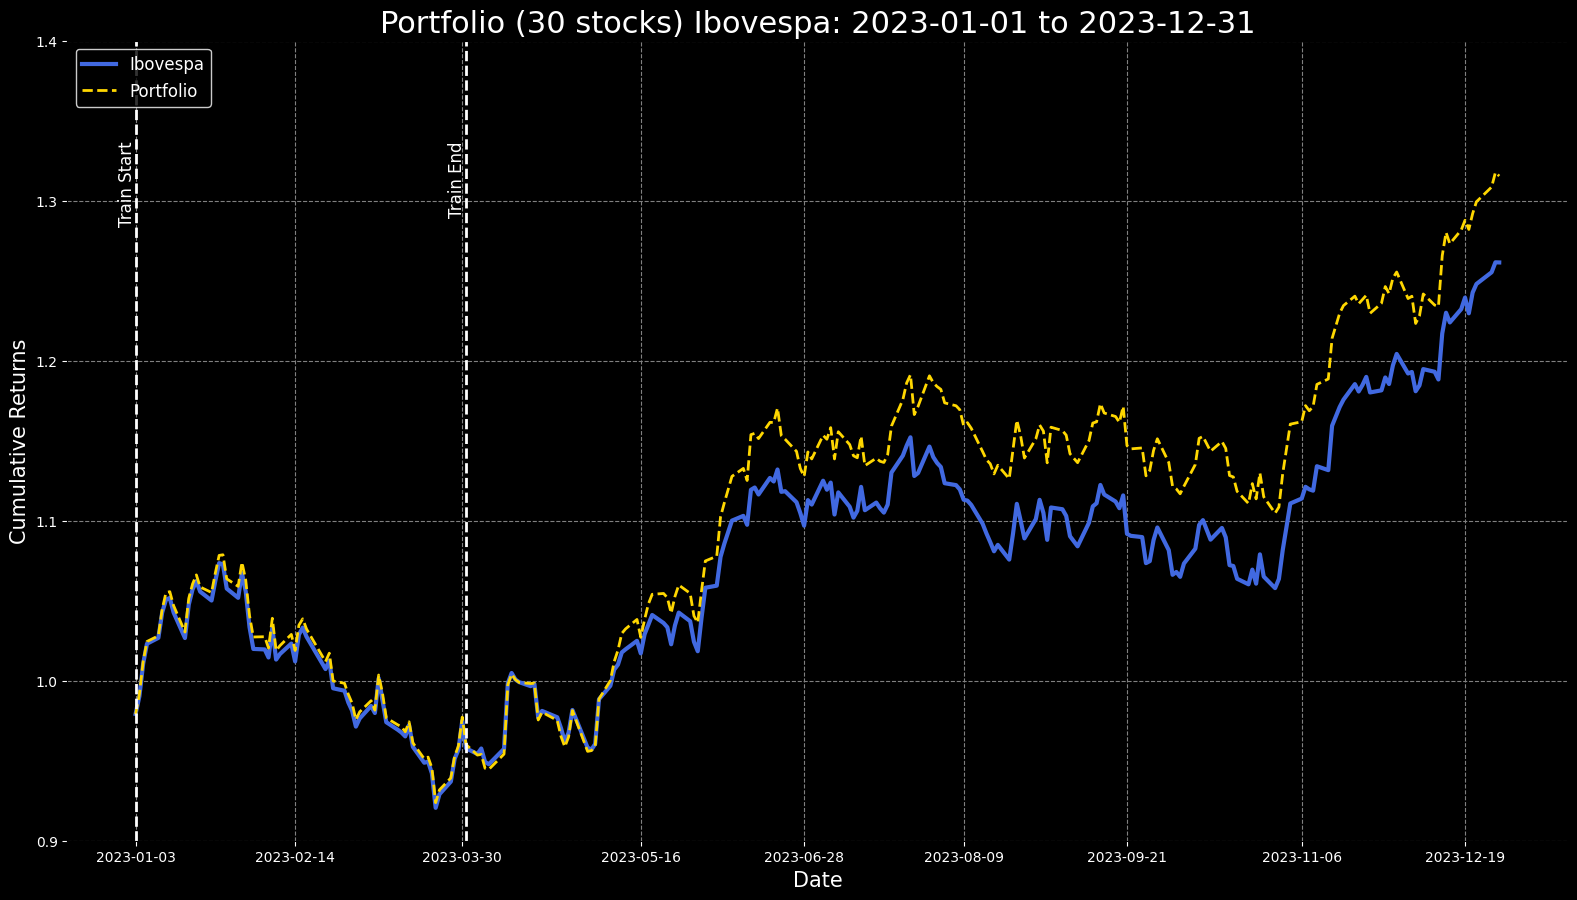

In [29]:
plot_portfolio(initial_bvsp_30stocks, bvsp_stocks_values, bvsp_index_values, start_date_dataset, end_date_dataset, 'Ibovespa')

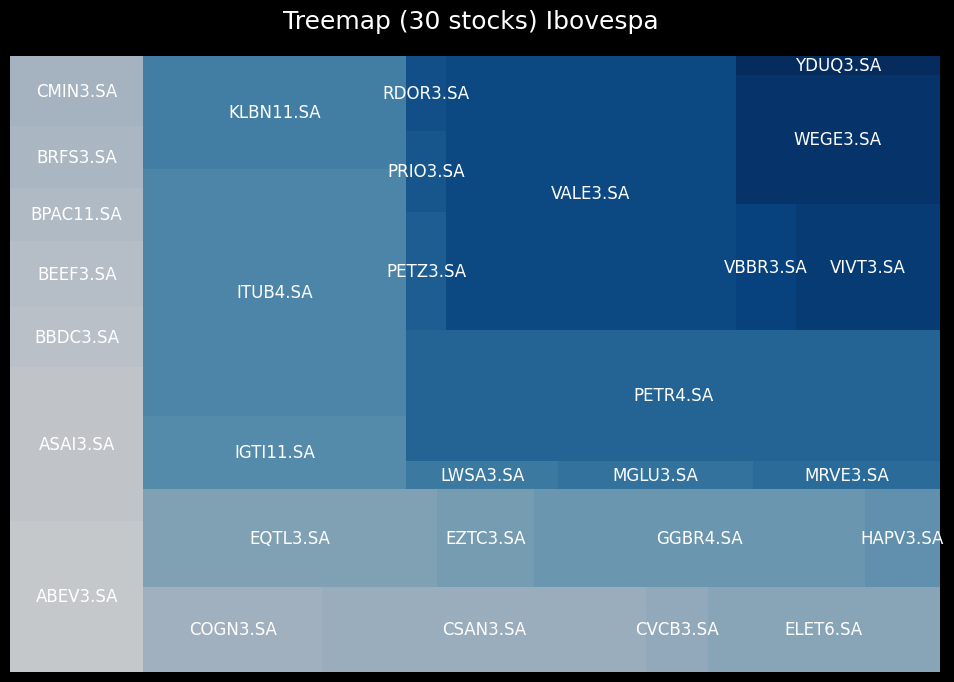

In [30]:
plot_weights(initial_bvsp_30stocks['weights'], index_name='Ibovespa')

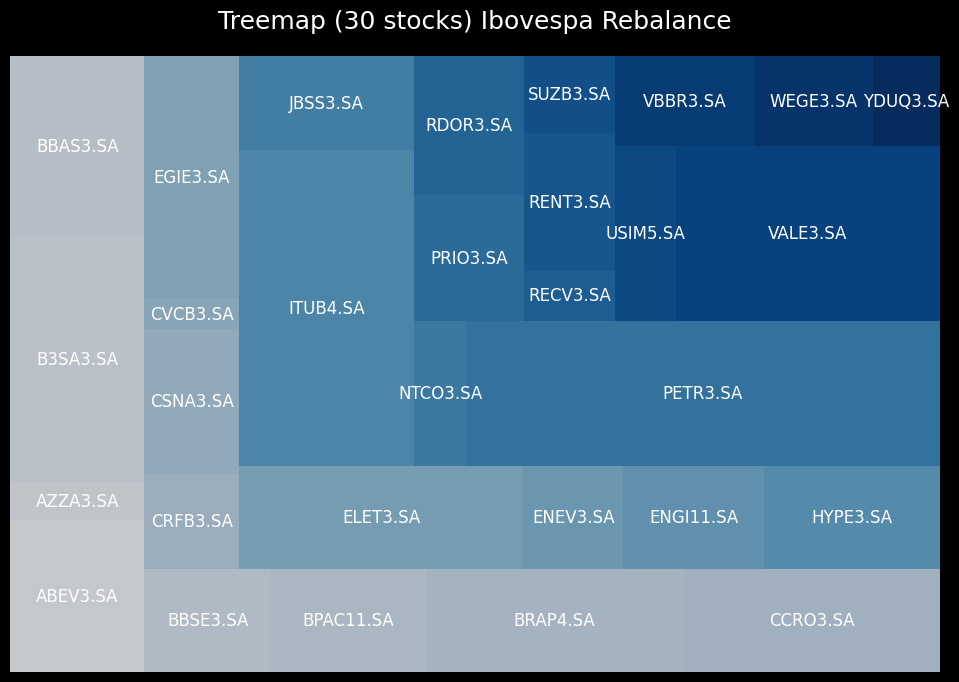

In [31]:
plot_weights(initial_rebalance_bvsp_30stocks['weights'], index_name='Ibovespa', rebalance=True)

## Métricas:

In [32]:
sp100_portfolios = [
    regular_sp100_10stocks, regular_sp100_20stocks, regular_sp100_30stocks
]
sp100_portfolios_initial = [
    initial_sp100_10stocks, initial_sp100_20stocks, initial_sp100_30stocks
]
bvsp_portfolios = [
    regular_bvsp_10stocks, regular_bvsp_20stocks, regular_bvsp_30stocks
]
bvsp_portfolios_initial = [
    initial_bvsp_10stocks, initial_bvsp_20stocks, initial_bvsp_30stocks
]

k_values = [10, 20, 30]

def extract_metrics(portfolios):
    return {
        'train_tracking_error': [p['performance']['train_performance']['tracking_error'] for p in portfolios],
        'test_tracking_error': [p['performance']['test_performance']['tracking_error'] for p in portfolios],
        'optimization_time': [p['optimization_time'] for p in portfolios],
    }

bvsp_metrics = extract_metrics(bvsp_portfolios)
sp100_metrics = extract_metrics(sp100_portfolios)
bvsp_metrics_initial = extract_metrics(bvsp_portfolios_initial)
sp100_metrics_initial = extract_metrics(sp100_portfolios_initial)

plt.style.use('dark_background')

def plot_line_chart(metric_name, regular, initial, title, index_name):
    if(index_name=='S&P100'):
        color1 = 'red'
        color2 = 'gold'
    else:
        color1 = 'royalblue'
        color2 = 'gold'
    plt.figure(figsize=(12, 6))
    plt.plot(k_values, regular, marker='s', label='Regular', color=color1, linewidth=2)
    plt.plot(k_values, initial, marker='o', label='Initial', color=color2, linewidth=2)
    plt.title(f"{index_name}: {title}", color='white')
    plt.xlabel('K Value', color='white')
    plt.ylabel('Value', color='white')
    plt.legend(facecolor='black', edgecolor='white')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_bar_chart(metric_name, regular, initial, title, index_name):
    if(index_name=='S&P100'):
        color1 = 'red'
        color2 = 'gold'
    else:
        color1 = 'royalblue'
        color2 = 'gold'
    plt.figure(figsize=(12, 6))
    x = range(len(k_values))
    width = 0.35
    plt.bar([i + width / 2 for i in x], regular, width, label='Regular', color=color1, edgecolor='white')
    plt.bar([i - width / 2 for i in x], initial, width, label='Initial', color=color2, edgecolor='white')
    plt.title(f"{index_name}: {title}", color='white')
    plt.xlabel('K Value', color='white')
    plt.ylabel('Value', color='white')
    plt.xticks(x, k_values, color='white')
    plt.legend(facecolor='black', edgecolor='white')
    plt.tight_layout()
    plt.show()

metrics_to_plot = [
    ('train_tracking_error', 'Train Tracking Error'),
    ('test_tracking_error', 'Test Tracking Error'),
    ('optimization_time', 'Optimization Time'),
]


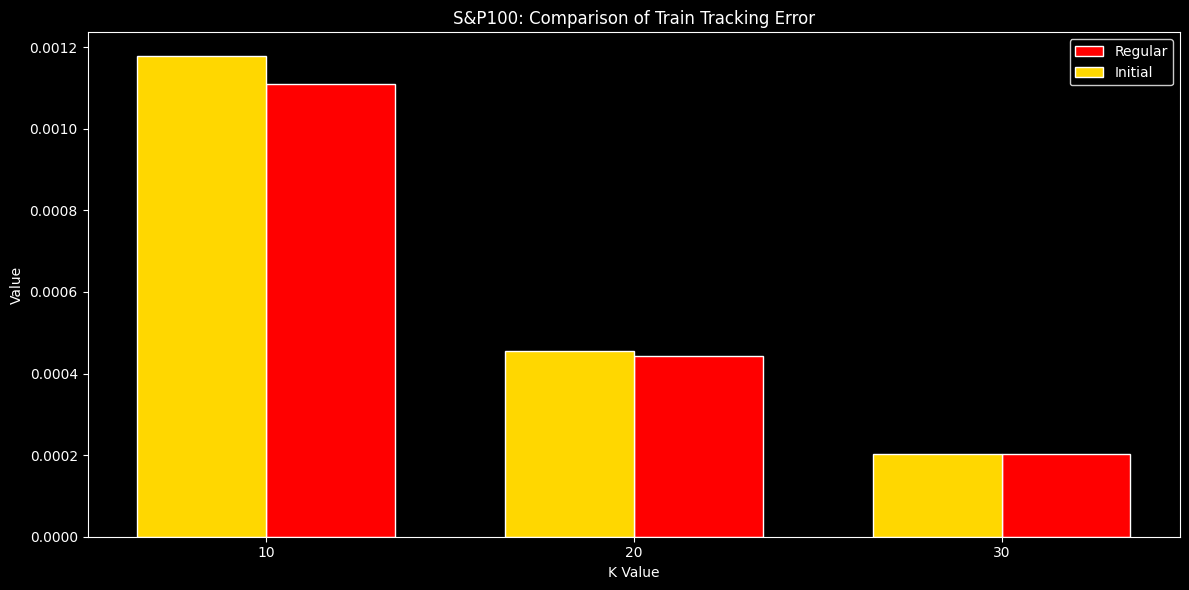

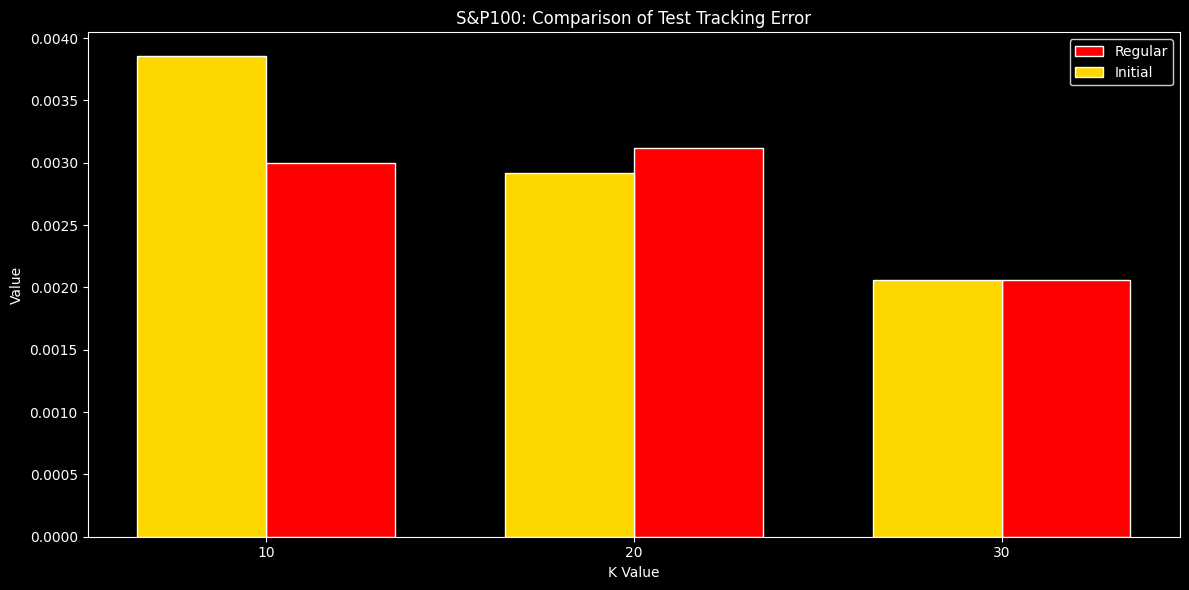

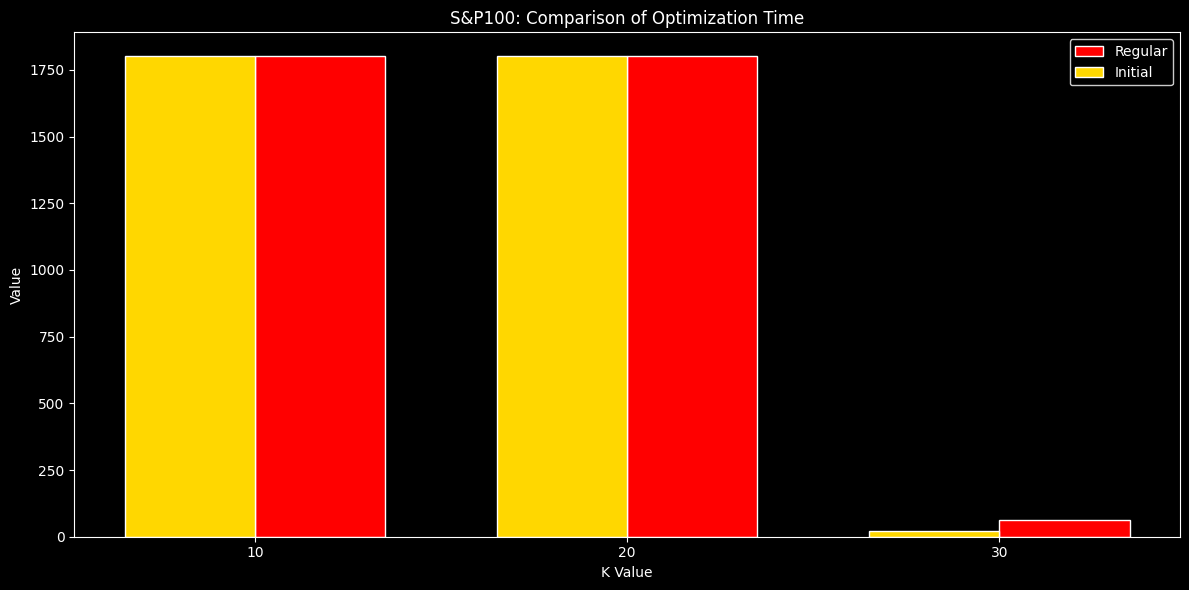

In [33]:
for metric_key, title in metrics_to_plot:
    plot_bar_chart(
        metric_key, 
        sp100_metrics[metric_key], 
        sp100_metrics_initial[metric_key], 
        f'Comparison of {title}',
        'S&P100'
    )

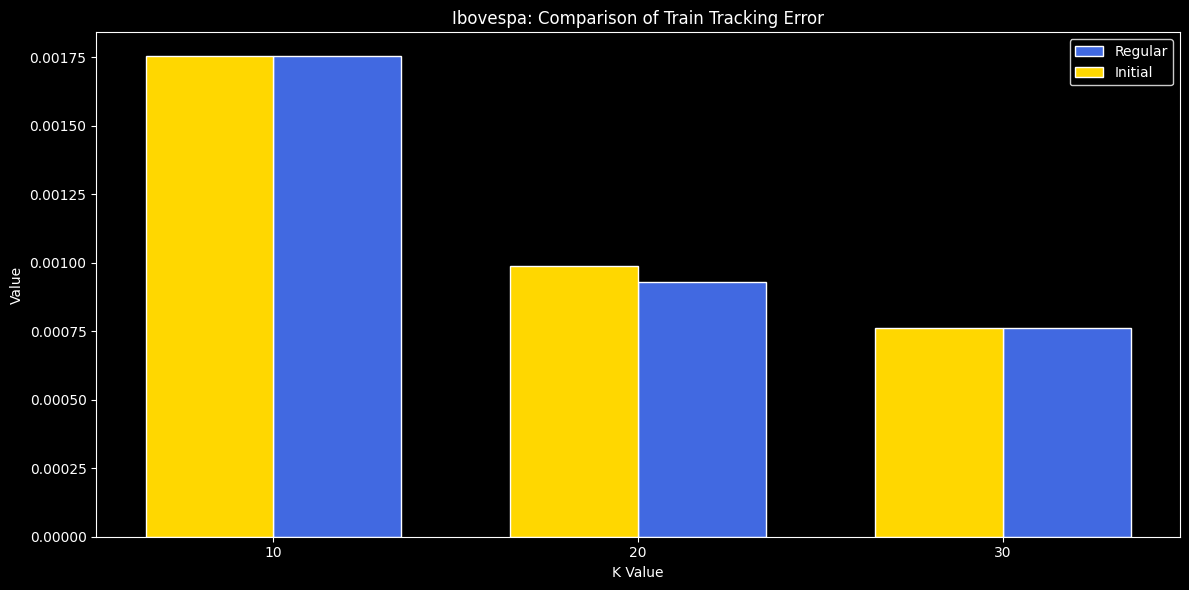

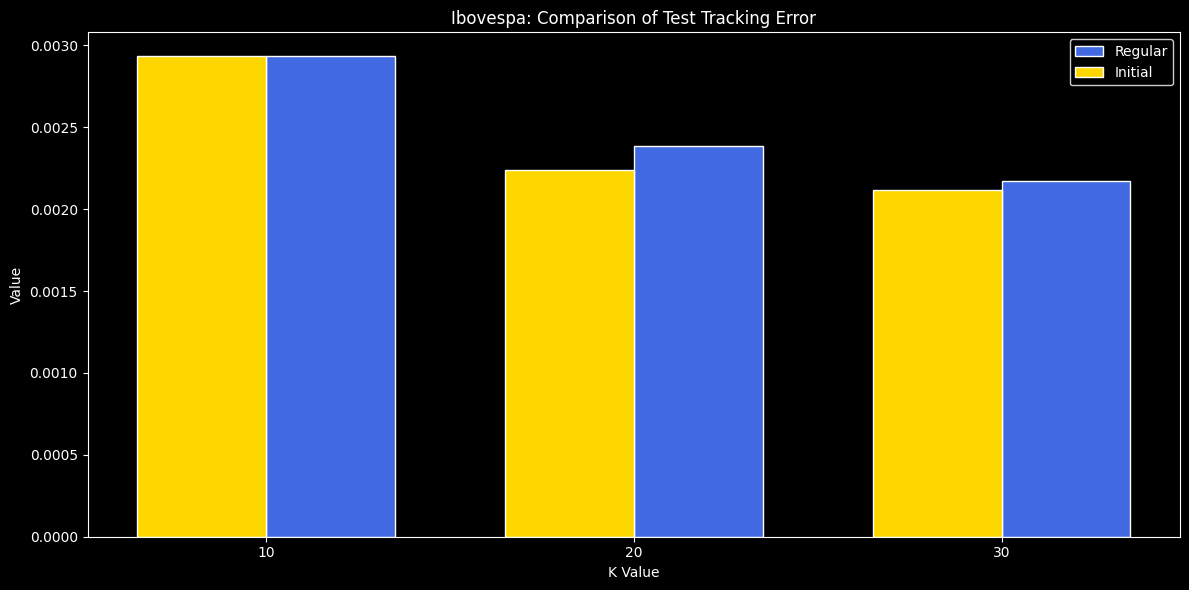

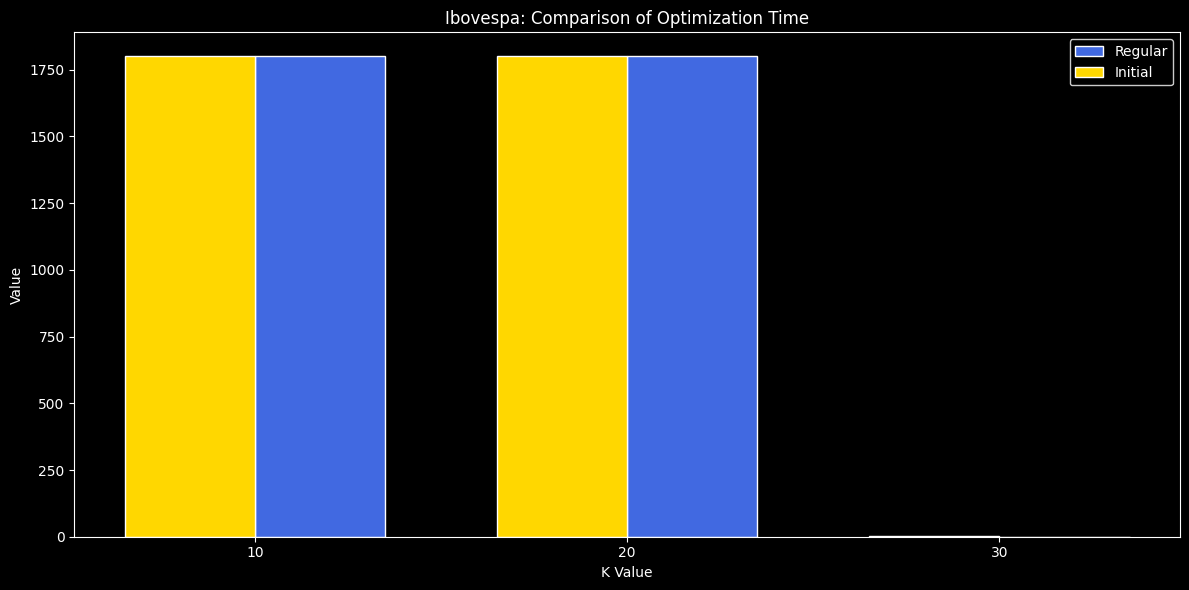

In [34]:
for metric_key, title in metrics_to_plot:
    plot_bar_chart(
        metric_key, 
        bvsp_metrics[metric_key], 
        bvsp_metrics_initial[metric_key], 
        f'Comparison of {title}',
        'Ibovespa'
    )